Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.random import choice
from sklearn import linear_model
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap
from numpy.random import choice
import random
from scipy.stats.stats import pearsonr, f_oneway
from scipy import stats
import pandas as pd
from statsmodels.formula.api import ols
import scipy

np.random.seed(seed=7)

<ipython-input-1-5c2dd0fdb1d4>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


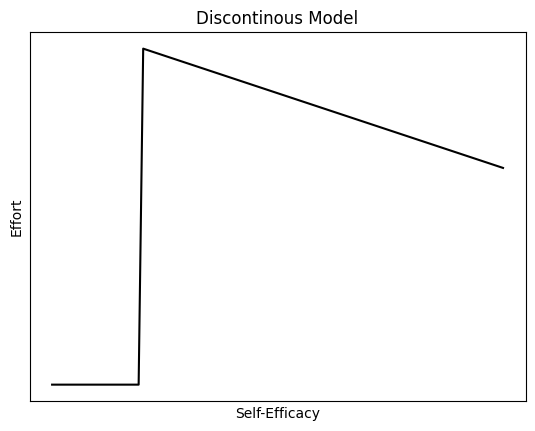

In [ ]:
# This is to replicate a figure from Vancouver et a., 2008


def vancouver_etal_2008_disc_model(xs):
  ys = []
  for x in xs:
    if x < .2:
      ys.append(0.01)
    else:
      ys.append(0.5-.2*x)

  return ys



fig = plt.figure()
ax = plt.axes()
x = np.linspace(0, 1, 100)
plt.title("Discontinous Model")
plt.xlabel("Self-Efficacy")
plt.ylabel("Effort")
plt.xticks([], [])
plt.yticks([], [])
ax.plot(x, vancouver_etal_2008_disc_model(x), '-k')

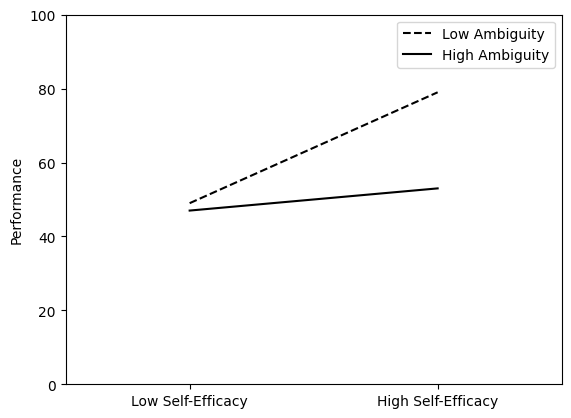

In [ ]:
# This is to replacate a figure from Schmidt and DeShon (2010)

fig = plt.figure()
ax = plt.axes()
x = [5, 15]
y1 = [47, 53]
y2 = [49, 79]
# plt.title("Discontinous Model")
# plt.xlabel("Self-Efficacy")
plt.ylabel("Performance")
my_xticks = ['Low Self-Efficacy','High Self-Efficacy']
plt.xticks(x, my_xticks)
ax.set_ylim(0, 100)
ax.set_xlim(0, 20)
ax.plot(x, y2, '--k', label='Low Ambiguity')
ax.plot(x, y1, '-k', label='High Ambiguity')
ax.legend()

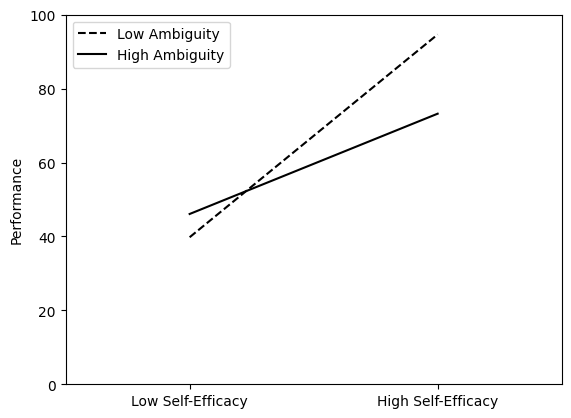

In [ ]:
# Figure 10 plot

y1 = (np.array([57.10131578947368, 67.55136054421769])/20-50)*35*3+4990
y2 = (np.array([58.30032840722496, 63.468650793650795])/20-50)*35*3+4990

fig = plt.figure()
ax = plt.axes()
x = [5, 15]

plt.ylabel("Performance")
my_xticks = ['Low Self-Efficacy','High Self-Efficacy']
plt.xticks(x, my_xticks)
ax.set_ylim(0, 100)
ax.set_xlim(0, 20)
ax.plot(x, y1, '--k', label='Low Ambiguity')
ax.plot(x, y2, '-k', label='High Ambiguity')
ax.legend()

Utilities

In [ ]:
def true_tanh(x):
  # (e^2x-1)/(e^2x+1)
  return (np.exp(2*x)-1)/(np.exp(2*x)+1)


def tanh(x):
  # ((e^2x-1)/(e^2x+1) + 1) / 2
  return ((np.exp(2*x)-1)/(np.exp(2*x)+1) + 1) / 2.

def tanh4(x):
  # same as def tanh(x):
  x = np.clip(x, 0, 1000)
  return np.tanh (x)


def np_f1(x):
  """
  From “Verguts et al., 2015”; F1(x) = (ex -1) / (ex + 1)) on page 11
  """
  x = np.clip(x, 0, 1000)
  # return (np.exp(x)-1)/(np.exp(x)+1)
  return np.tanh(x)


def bol(U, t):
  U = np.array(U)
  U = np.reshape(U, newshape=(U.shape[0], 1))
  init_shape = U.shape

  if np.min(U) == np.max(U) == 0:
    res = np.zeros(shape=init_shape)
    return res

  U = np.reshape(U, newshape=(1, -1))
  U_ = np.exp(U / t)
  s = np.sum(U_, axis=1)
  s = np.reshape(s, newshape=(s.shape[0], 1))

  res = U_ / s
  res = np.reshape(res, newshape=init_shape)

  return res


def gaussian(x, mu):
  return np.exp( (-(x - mu)**2) / (1/8) )


def perc(b, se, effort):

  return b*se*effort

def eel_np(value_g, se, el_j, a, c):
  # Average effort level or expected (E(EL))
  # Returns Bolzman activation of Utility values and E(EL)

  N = len(list(se))

  se = np.reshape(se, newshape=[N, 1])

  el_j = np.array(el_j)
  el_n = el_j.shape[0]
  el_j = np.reshape(el_j, newshape=[el_n, 1])

  value = np.ones(shape=[N, 1])* value_g
  benefit = np.einsum('no, eo -> noe', se, el_j)
  benefit = np.reshape(benefit, newshape=[N, el_n])
  benefit = np.einsum('ne, no -> noe', np_f1(a*benefit), value)
  benefit = np.reshape(benefit, newshape=[N, el_n])
  cost = np.ones(shape=[N, 1])*c
  cost = np.einsum('no, eo -> noe', cost, el_j)
  cost = np.reshape(cost, newshape=[N, el_n])
  u = benefit - cost
  u_b = []
  assert(len(u.shape) == 2)

  for i in range(u.shape[0]):
    u_bol = bol(u[i], tau)
    u_bol = np.reshape(u_bol, newshape=(-1))
    u_b.append(np.array(u_bol))

  u_b = np.array(u_b)
  u_b = np.reshape(u_b , newshape=u.shape)

  eel = np.einsum('ne, eo -> neo', u_b, el_j)
  eel = np.sum(eel, axis=1)
  eel = np.reshape(eel , newshape=(N, 1))

  return eel, u_b

def rea_util(t, T, el_j=np.arange(0.1,1.1,.1), cu_perc=0, el=None, value_g=None, se=None, a=None, c=None, eel=None,
             b=None, ext_fb=-1, ret_util=False, use_perc=False, b_prime=None, ret_bol_util=False, toa=None):
  '''
  t - timestep
  T - total number of timesteps
  el_j - effort levels
  cu_perc - percepted cumulative task progress
  el - effort level
  value_g - value(g)
  se - self-efficacy
  a - parameter a
  c - paraemter c
  eel - expectation of the effort level, E(EL)
  b - parameter b;
  ext_fb: external feedback (1 - success; 0 - no success; -1 - no feedback)
  ret_util: return utility value;
  use_perc: use perc (percepted task progress) value
  b_prime: value of b' parameter;
  ret_bol_util: return boltzmann distribution of utility values;

  Input ‘type of ambiguity (toa)’ separates:
  so-called “ambiguous” condition with info re success of a step (toa=3)
  completely ‘unambiguous’ condition (toa=2).
  completely ambiguous condition will be: toa=1.
  '''

  k_perc = cu_perc
  eos=False
  if t == 0:
    N = len(list(se))

    se = np.reshape(se, newshape=[N, 1])
    el_n = el_j.shape[0]
    el_j = np.reshape(el_j, newshape=[el_n, 1])

    value = np.ones(shape=[N, 1])*value_g
    benefit = np.einsum('no, eo -> noe', se, el_j)
    benefit = np.reshape(benefit, newshape=[N, el_n])
    benefit = np_f1(a*benefit)
    benefit = np.einsum('ne, no -> noe', benefit, value)
    benefit = np.reshape(benefit, newshape=[N, el_n])
    cost = np.ones(shape=[N, 1])*c
    cost = np.einsum('no, eo -> noe', cost, el_j)
    cost = np.reshape(cost, newshape=[N, el_n])

    perc_t = 0

    benefit_t = benefit * (1 - perc_t)
    cost_t = cost * (1 - perc_t)

    u = benefit_t - cost_t

    u_b = []
    el_prime = []
    assert(len(u.shape) == 2)

    for i in range(u.shape[0]):
      u_bol = bol(u[i], tau)
      u_bol = np.reshape(u_bol, newshape=(-1))
      u_b.append(np.array(u_bol))
      el_prime.append(np.random.choice(np.reshape(el_j, newshape=(-1)), 1, p=u_bol))

    u_b = np.array(u_b)
    u_b = np.reshape(u_b , newshape=u.shape)

    eel = np.einsum('ne, eo -> neo', u_b, el_j)
    eel = np.sum(eel, axis=1)
    eel = np.reshape(eel , newshape=(N, 1))

    if ext_fb < 0:
      b = .5
    else:
      b = .2
    k_perc += perc_t

    return eel, b, u, u_b, b_prime, eos, el_prime, k_perc

  else:

    if ext_fb >= 0:
      """
      Feedback: perc = percentage of task items completed at timestep t-1 out of all the items remaining to be completed.
      benefit_j, t <- benefit_j, t-1 * (1 - perc) (similar for cost_j,t)
      Select EL_t (possibly no effort at all for the tasks that are ignored)
      """
      N = len(list(se))
      se = np.reshape(se, newshape=[N, 1])
      k_perc = cu_perc

      el_n = el_j.shape[0]
      el_j = np.reshape(el_j, newshape=[el_n, 1])

      value = np.ones(shape=[N, 1])*value_g
      benefit = np.einsum('no, eo -> noe', se, el_j)
      benefit = np.reshape(benefit, newshape=[N, el_n])
      benefit = np_f1(a*benefit)
      benefit = np.einsum('ne, no -> noe', benefit, value)
      benefit = np.reshape(benefit, newshape=[N, el_n])
      cost = np.ones(shape=[N, 1])*c
      cost = np.einsum('no, eo -> noe', cost, el_j)
      cost = np.reshape(cost, newshape=[N, el_n])
      benefit_t = benefit
      cost_t = cost

      no_eval = False

      if use_perc:
        if ext_fb ==  0:
          perc_t = 0
          no_eval = True
        else:
          if toa == 3:
            b_prev_t = b
            el_prev_t = np.reshape(el, newshape=(N, 1))
            perc_t = b_prev_t * se
            perc_t = np.einsum('no, no -> no', perc_t, el_prev_t)
            perc_t = tanh4(perc_t)
          else:
            perc_t = tanh4(ext_fb)


          if k_perc < 1.:

            benefit_t = benefit * (1 - perc_t)
            cost_t = cost * (1 - perc_t)
            u = benefit_t - cost_t

            u_b = []
            el_prime = []
            assert(len(u.shape) == 2)

            for i in range(u.shape[0]):
              u_bol = bol(u[i], tau)
              u_bol = np.reshape(u_bol , newshape=(-1))
              u_b.append(np.array(u_bol))
              el_prime.append(np.random.choice(np.reshape(el_j , newshape=(-1)), 1, p=u_bol))

            u_b = np.array(u_b)
            u_b = np.reshape(u_b , newshape=u.shape)

            eel = np.einsum('ne, eo -> neo', u_b, el_j)
            eel = np.sum(eel, axis=1)
            eel = np.reshape(eel , newshape=(N, 1))
          else:
            el_prime = np.zeros(shape=(N, 1))
            u = np.zeros(shape=(N, 1))
            u_b = np.zeros(shape=(N, 1))
            eel = np.zeros(shape=(N, 1))
            eos = True

          if b_prime:
            b_prime = b_prime / (1-perc_t)

        k_perc += perc_t
      else:
        no_eval = True

      if no_eval:
        benefit_t = benefit
        cost_t = cost
        u = benefit_t - cost_t
        u_b = []
        el_prime= []
        assert(len(u.shape) == 2)

        for i in range(u.shape[0]):
          u_bol = bol(u[i], tau)
          u_bol = np.reshape(u_bol , newshape=(-1))
          u_b.append(np.array(u_bol))
          el_j_flt = np.reshape(el_j , newshape=(-1))
          el_prime.append(np.random.choice(el_j_flt, 1, p=u_b[i]))

        u_b = np.array(u_b)
        u_b = np.reshape(u_b , newshape=u.shape)


        eel = np.einsum('ne, eo -> neo', u_b, el_j)
        eel = np.sum(eel, axis=1)
        eel = np.reshape(eel , newshape=(N, 1))
        el_prime = np.reshape(el_prime , newshape=(N, 1))


      return eel, b, u, u_b, b_prime, eos, el_prime, k_perc

    else:
      """
      Get EL_t-1
      perc = b_t-1 * SE * effort, where effort = EL_t-1
      E.g. b_t-1 = 1; SE = 0.5; effort = .55 -> perc = .25
      benefit_j, t <- benefit_j, t-1 * (1 - perc) (similar for cost_j,t)
      Select EL_t (possibly no effort at all for the tasks that are ignored)
      b_t = b_t-1 / (1-perc)
      """

      k_perc = cu_perc
      N = len(list(se))
      b_prev_t = b

      if math.isinf(b_prev_t):
        eel = np.zeros(shape=(N, 1))
        el = np.zeros(shape=(N, 1))
        b_t = float("Inf")
        u_b = np.zeros(shape=(N, 1))
        u = np.zeros(shape=(N, 1))

        return eel, b_t, u, u_b, b_prime, eos, el


      se = np.reshape(se, newshape=[N, 1])
      eel = np.reshape(eel, newshape=(N, 1))
      eel_prev_t = eel
      el_n = el_j.shape[0]
      el_j = np.reshape(el_j, newshape=[el_n, 1])

      value = np.ones(shape=[N, 1])*value_g
      benefit = np.einsum('no, eo -> noe', se, el_j)
      benefit = np.reshape(benefit, newshape=[N, el_n])
      benefit = np_f1(a*benefit)
      benefit = np.einsum('ne, no -> noe', benefit, value)
      benefit = np.reshape(benefit, newshape=[N, el_n])
      cost = np.ones(shape=[N, 1])*c
      cost = np.einsum('no, eo -> noe', cost, el_j)
      cost = np.reshape(cost, newshape=[N, el_n])

      perc_t = b_prev_t * se

      if el:
        el_prev_t = np.reshape(el, newshape=(N, 1))
        perc_t = np.einsum('no, no -> no', perc_t, el_prev_t)
      else:
        perc_t = np.einsum('no, no -> no', perc_t, eel_prev_t)

      perc_t = tanh4(2 * perc_t)

      b_t = b_prev_t

      if b_prime:
        b_prime = b_prime / (1-perc_t)

      if k_perc < 1.:
        benefit_t = benefit * (1 - perc_t)
        cost_t = cost * (1 - perc_t)
        u = benefit_t - cost_t

        u_b = []
        el_prime= []
        assert(len(u.shape) == 2)
        for i in range(u.shape[0]):
          u_bol = bol(u[i], tau)
          u_bol = np.reshape(u_bol , newshape=(-1))
          u_b.append(np.array(u_bol))
          el_prime.append(np.random.choice(np.reshape(el_j, newshape=(-1)), 1, p=u_bol))

        u_b = np.array(u_b)
        u_b = np.reshape(u_b , newshape=u.shape)

        eel = np.einsum('ne, eo -> neo', u_b, el_j)
        eel = np.sum(eel, axis=1)
        eel = np.reshape(eel , newshape=(N, 1))
      else:
        b_prime = 10^8

        el_prime = np.zeros(shape=(el_n, 1))
        u = np.zeros(shape=(el_n, 1))
        u_b = np.zeros(shape=(el_n, 1))
        eel = np.zeros(shape=(N, 1))
        eos=True

      k_perc += perc_t

      return eel, b_t, u, u_b, b_prime, eos, el_prime, k_perc



def figure_z(a, c, tau, value_g):
  se = np.arange(0.01,1.1,.01)
  N = len(list(se))
  se = np.reshape(se, newshape=[N, 1])

  el_j = np.arange(0.1,1.1,.1)
  el_n = el_j.shape[0]
  el_j = np.reshape(el_j, newshape=[el_n, 1])

  value = np.ones(shape=[N, 1])*value_g

  benefit = np.einsum('no, eo -> noe', se, el_j)
  benefit = np.reshape(benefit, newshape=[N, el_n])

  benefit = np.einsum('ne, no -> noe', np_f1(a*benefit), value)
  benefit = np.reshape(benefit, newshape=[N, el_n])

  cost = np.ones(shape=[N, 1])*c
  cost = np.einsum('no, eo -> noe', cost, el_j)
  cost = np.reshape(cost, newshape=[N, el_n])

  u = benefit - cost
  plt.plot(se, u[:, 0], 'r', label='Lowest Effort Level' )
  plt.plot(se, u[:, el_n-1], 'g', label='Highest Effort Level')
  plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
  plt.ylabel('U')
  plt.xlabel('SE')
  plt.show()

  u_bol = []
  assert(len(u.shape) == 2)
  for i in range(u.shape[0]):
    u_b = bol(u[i], tau)
    u_bol.append(np.array(u_b))

  u_b = np.array(u_bol)
  u_b = np.reshape(u_b, newshape=[N, el_n])

  eel = np.einsum('ne, eo -> neo', u_b, el_j)
  eel = np.sum(eel, axis=1)
  eel = np.reshape(eel , newshape=(N, 1))

  plt.plot(se, eel)
  plt.ylabel('EL Expectation')
  plt.xlabel('SE')
  plt.show()


Theoretical simul #1 Effects of Manipulated SE

a= 5.5 tau= 0.01 c= 0.5


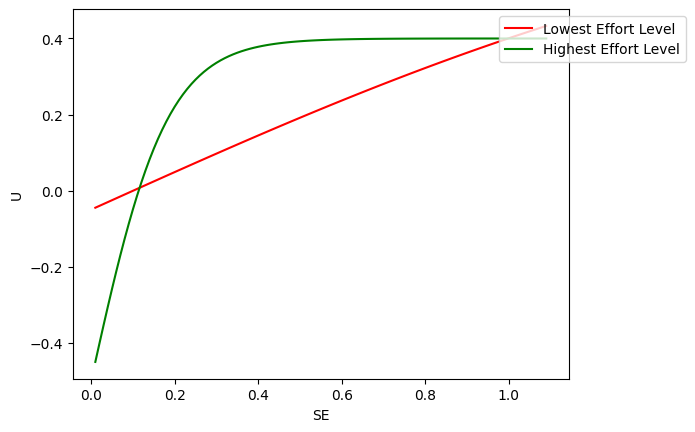

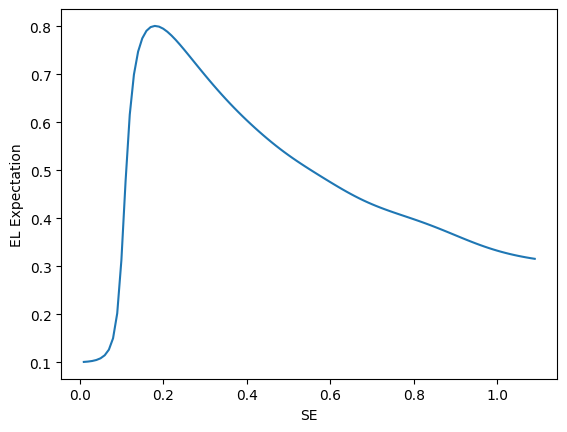

In [ ]:
C   = [.5] #np.linspace(start=0.01, stop=0.9, num=2) # [.5]#, 0.1] #np.arange(0.01, 0.06, .01)  #[0.09]
TAU = [0.01] #np.arange(0.1, 1.1, .1)
A   = [11/2] # np.linspace(start=1.0, stop=11., num=2) # [11/2]#, 5/2, 1/2] #np.arange(1.,  11., 1.)
VALUE_G = .9# 0.9


for a in A:
  for tau in TAU:
    for c in C:
      print('a=', a, 'tau=', tau, 'c=', c)

      figure_z(a=a, c=c, tau=tau, value_g=VALUE_G)


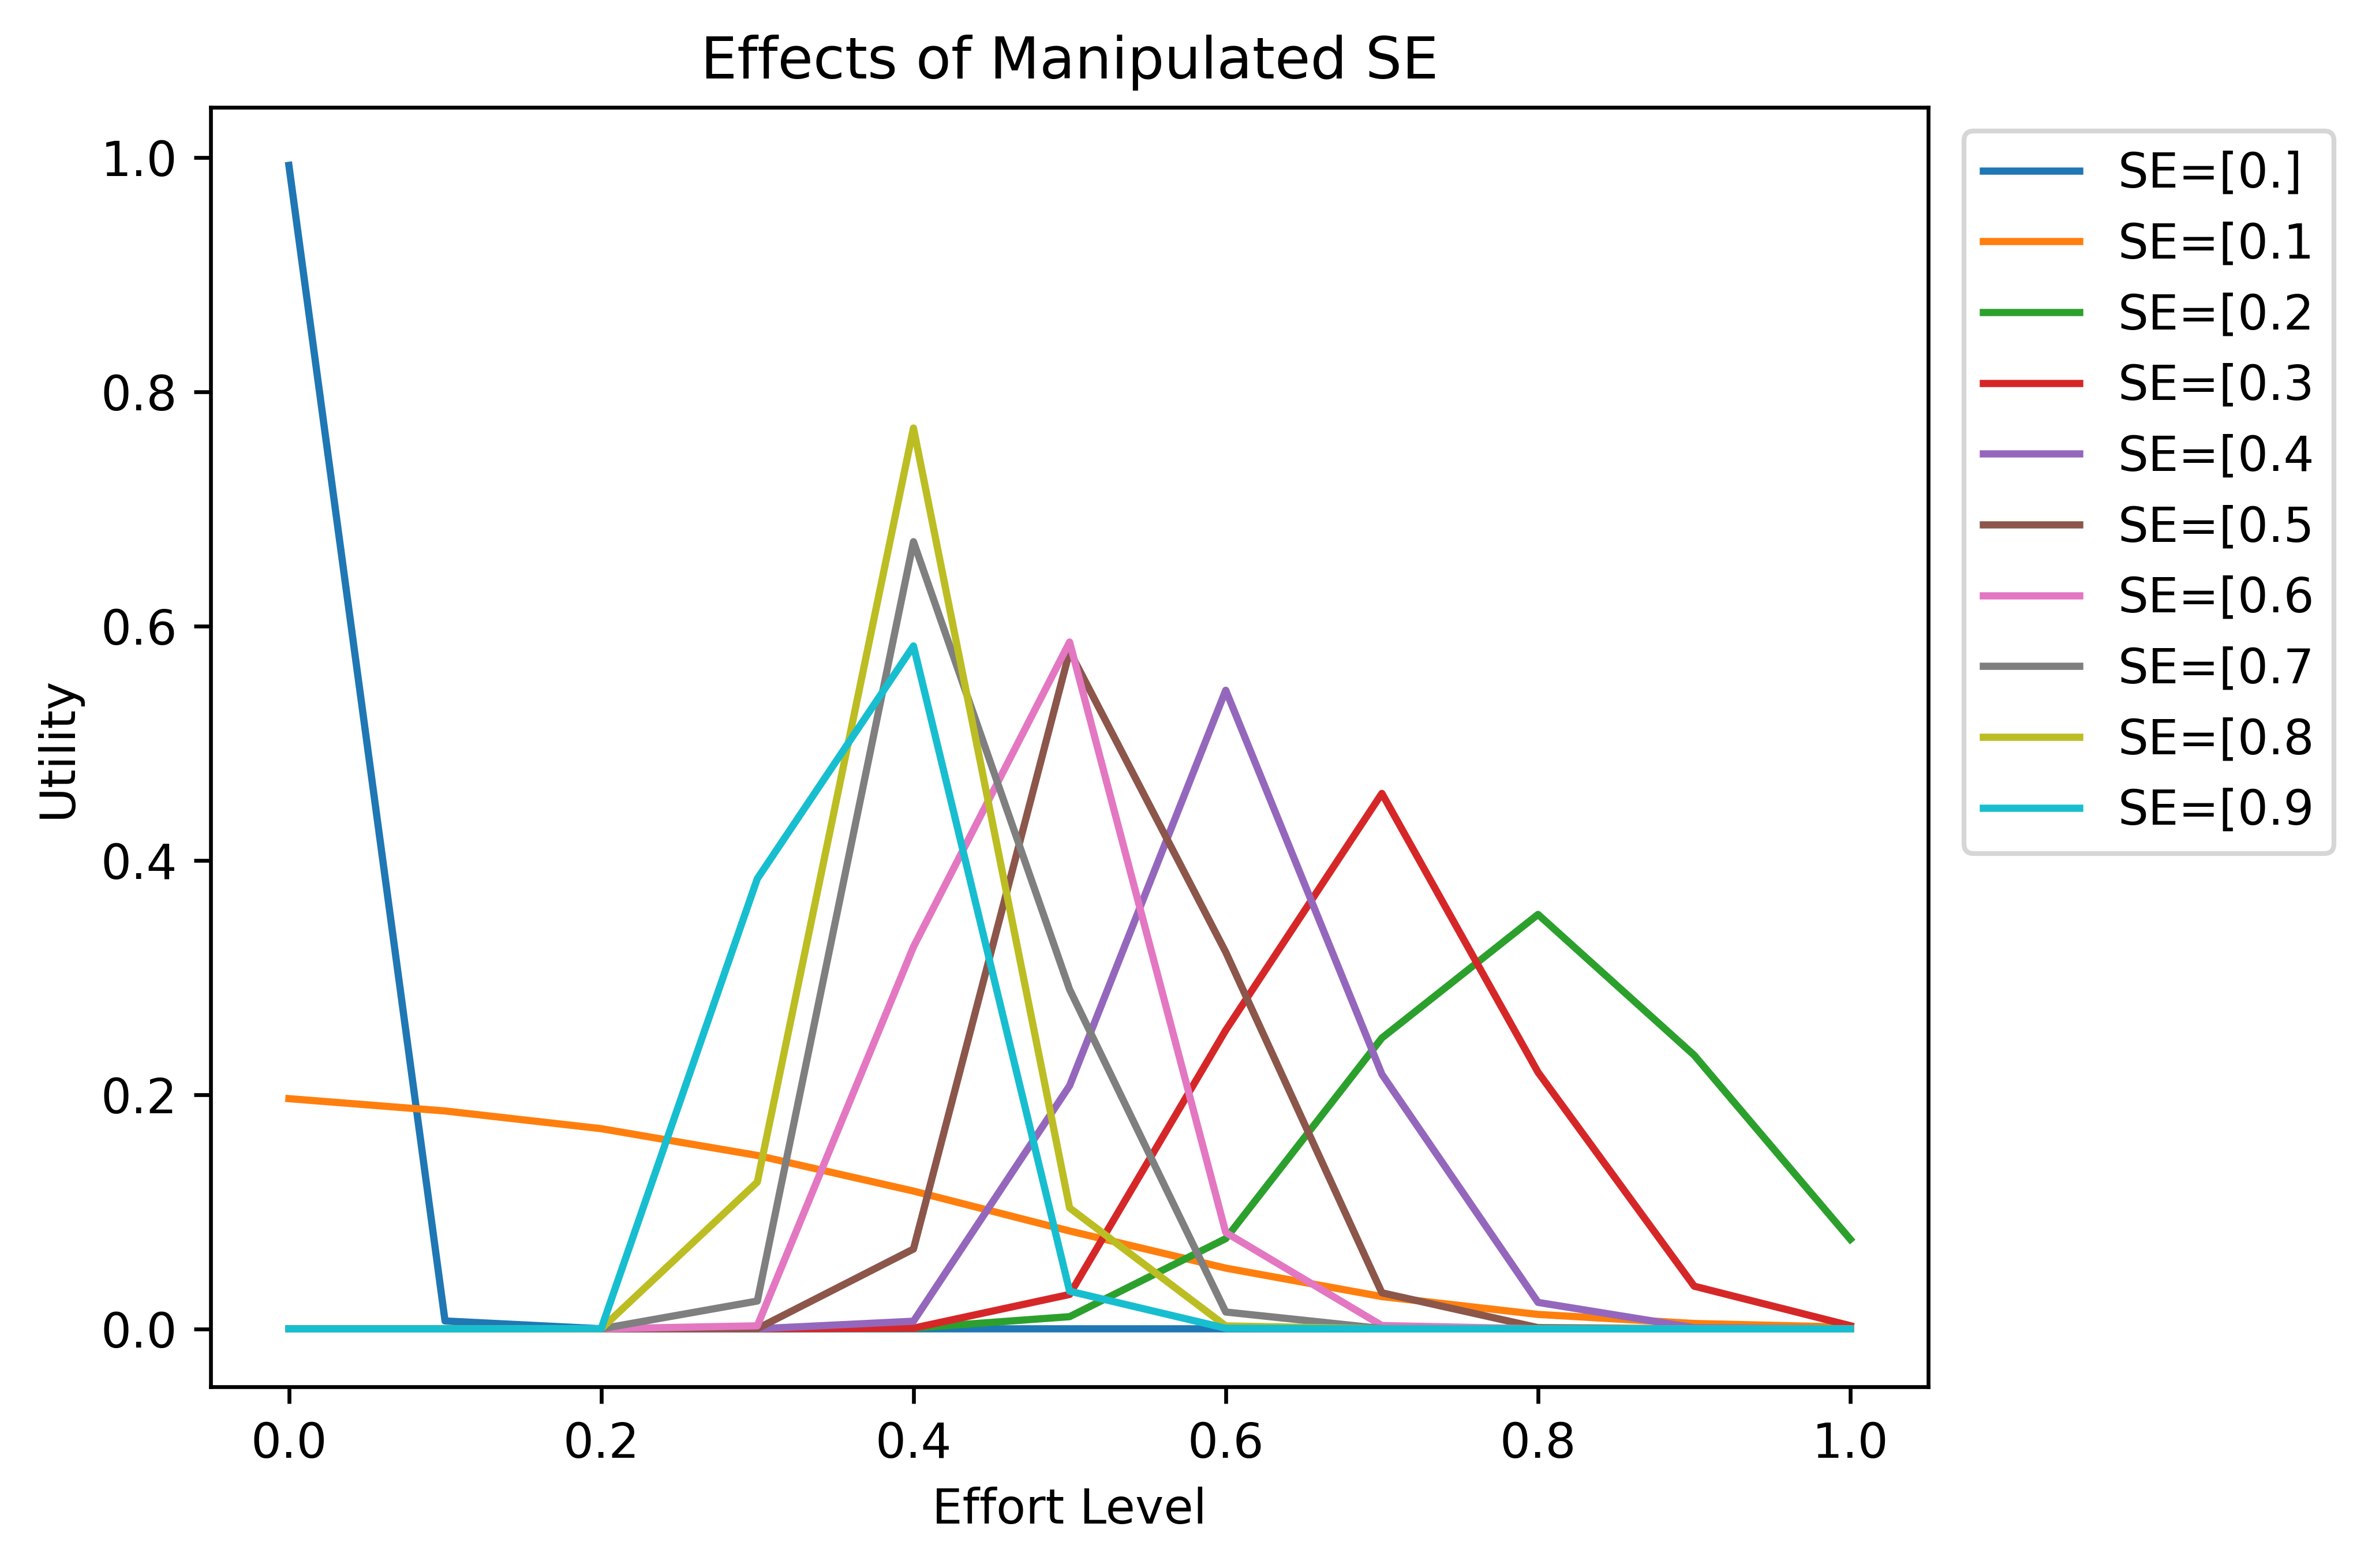

In [ ]:
# Effects of Manipulated SE v 2

colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
plt.figure(dpi=600)
a = 11/2
tau = 0.01
c = 0.5
se = np.arange(0.0,1.0,.1)
value_g = VALUE_G

N = len(list(se))
se = np.reshape(se, newshape=[N, 1])

el_j = np.arange(0.0,1.1,.1)
el_n = el_j.shape[0]
el_j = np.reshape(el_j, newshape=[el_n, 1])

value = np.ones(shape=[N, 1])*value_g
benefit = np.einsum('no, eo -> noe', se, el_j)
benefit = np.reshape(benefit, newshape=[N, el_n])
benefit = np.einsum('ne, no -> noe', np_f1(a*benefit), value)
benefit = np.reshape(benefit, newshape=[N, el_n])
cost = np.ones(shape=[N, 1])*c
cost = np.einsum('no, eo -> noe', cost, el_j)
cost = np.reshape(cost, newshape=[N, el_n])

perc_t = 0
benefit_t = benefit * (1 - perc_t)
cost_t = cost * (1 - perc_t)

u = benefit_t - cost_t

u_b = []
assert(len(u.shape) == 2)
for i in range(u.shape[0]):
  u_bol = bol(u[i], tau)
  u_b.append(np.array(u_bol))

u_b = np.array(u_b)
u_b = np.reshape(u_b , newshape=u.shape)

for i in range(N):
  se_i = se[i]
  u_b_avg = u_b[i]
  plt.plot(el_j, u_b_avg, label='SE='+str(se_i)[:4])

plt.ylabel('Utility')
plt.xlabel('Effort Level')
plt.title("Effects of Manipulated SE")
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
plt.show()
print(" ")

Effects of Ambiguity

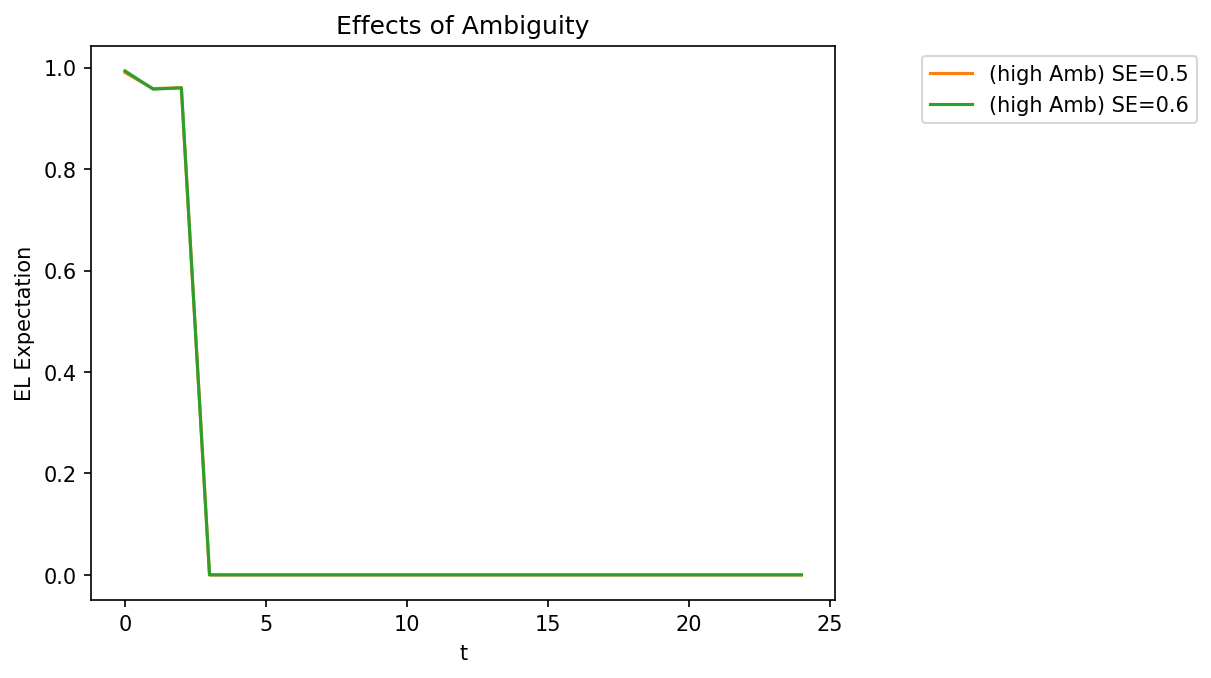

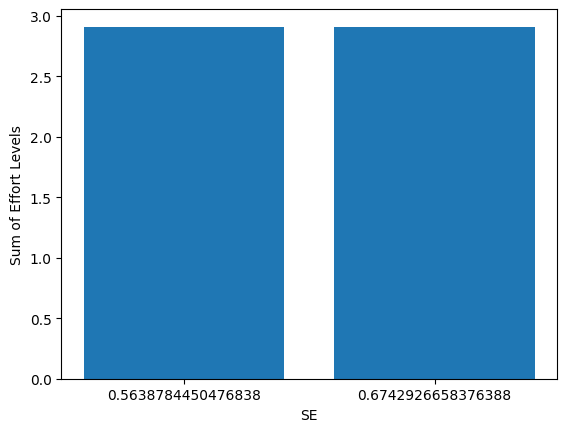

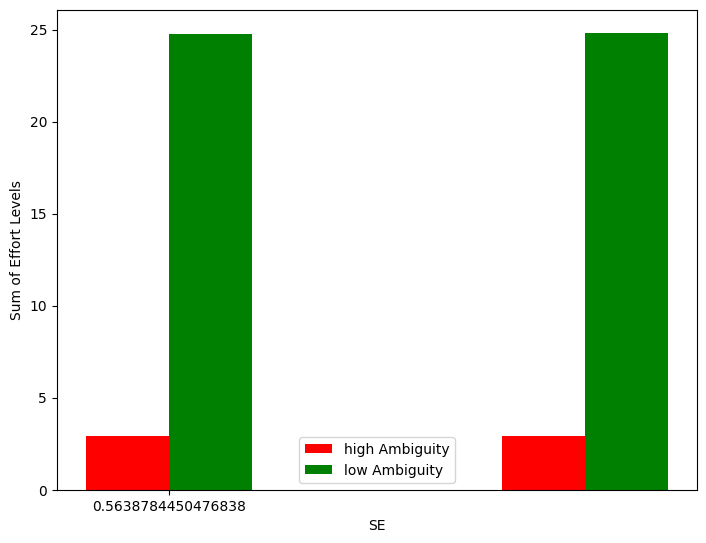

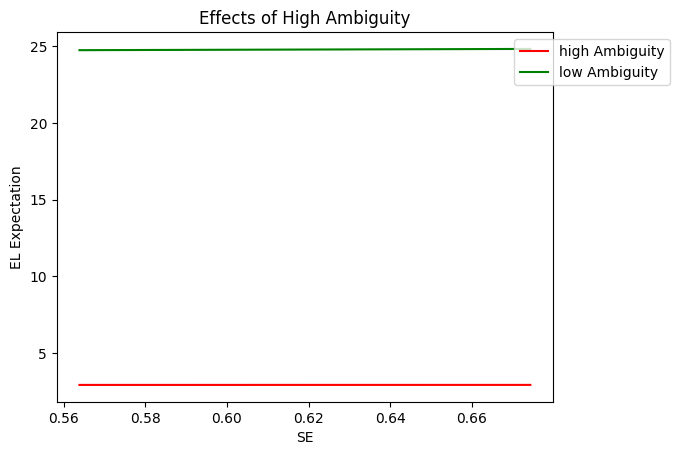

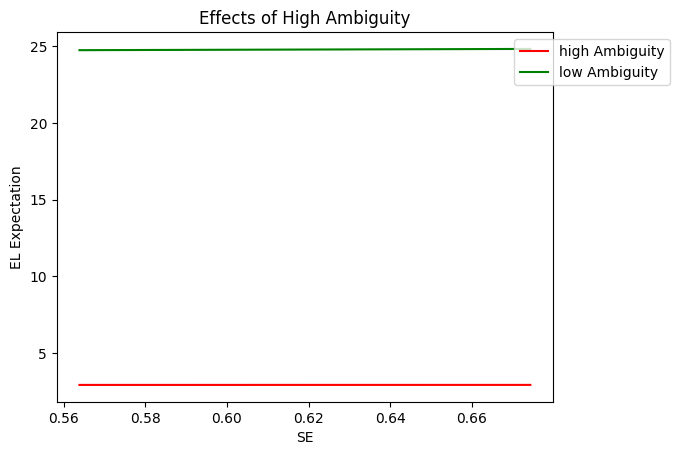

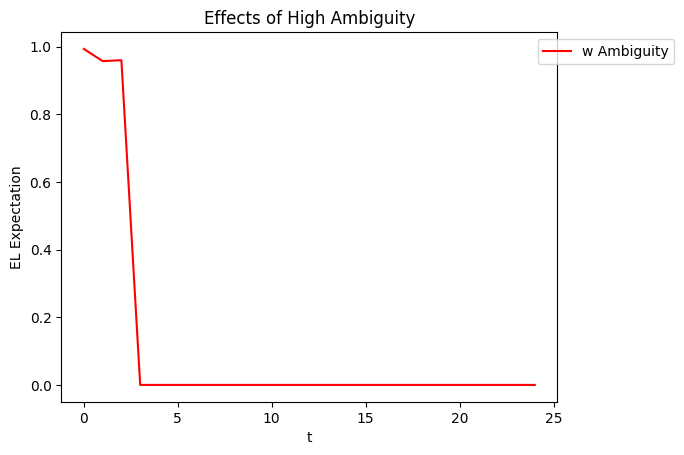

In [ ]:
# Effects of Ambiguity

VALUE_G = .9
colIndx = 0
plt.figure(dpi=150)
SEs =  [0.5638784450476838, 0.6742926658376388] #[0.5317939686066374, 0.7994706683084376] [0.5638784450476838, 0.6742926658376388]#[0.1, 0.8]#[0.1,.4,0.6,0.8, 1.]
eel_se = []
eel_se2 = []

T = 25
a = .8
tau = 0.01
c = .1

for se in SEs:
  colIndx += 1

  se = [se]
  N = len(list(se))
  se = np.reshape(se, newshape=[N, 1])

  eel_t = []
  b = 1
  eel=None

  eel_t2 = []
  b2 = 1
  eel2=None

  b_prime_o = 1.25

  eos1 = False
  eos2 = False

  cu_perc1 = 0
  cu_perc2 = 0

  for t in range(0, T):
    # w Ambiguity
    if eos1:
      pass
    else:
      eel, b, _, _, _, eos1, _ , cu_perc1 = rea_util(t=t, T=T, value_g=VALUE_G, cu_perc = cu_perc1, se=se, a=a, c=c, eel=eel, b=b, ext_fb=-1)
    eel_t.append(eel)

    if t == 0:
      fb = 0
      b_prime = b_prime_o
    else:
      fb = eel2 * b_prime

    if eos2:
      pass
    else:
      eel2, b2, _, _, b_prime, eos2, _ , cu_perc2 = rea_util(t=t, T=T, value_g=VALUE_G, cu_perc = cu_perc2, se=se, a=a, c=c, eel=eel2, b=b2, ext_fb=fb, b_prime=b_prime)

    eel_t2.append(eel2)

    eel_se.append(eel)
    eel_se2.append(eel2)


  eel_t = np.reshape(eel_t, [-1])
  eel_t2 = np.reshape(eel_t2, [-1])
  col = 'C' + str(colIndx)
  plt.plot(range(0, T), eel_t, col, label='(high Amb) SE='+str(se[0,0])[:3])

  col = 'C' + str(colIndx+len(list(SEs)))

plt.legend(loc='upper right', bbox_to_anchor=(1.5,1.))
plt.ylabel('EL Expectation')
plt.xlabel('t')
plt.title("Effects of Ambiguity")
plt.show()


eel_se = np.reshape(eel_se, [len(list(SEs)), -1])
eel_se = np.sum(eel_se, axis=1)

eel_se2 = np.reshape(eel_se2, [len(list(SEs)), -1])
eel_se2 = np.sum(eel_se2, axis=1)

plt.ylabel('Sum of Effort Levels')
plt.xlabel('SE')
SEs_str = [str(se) for se in SEs]
plt.bar(SEs_str, eel_se)
plt.show()


fig = plt.figure()

ind = np.arange(len(SEs_str))

ax = fig.add_axes([0,0,1,1])
ax.set_xticks(np.linspace(0.1, 4.1, num=len(SEs_str)))#[0.1, 1.1, 2.1, 3.1, 4.1])
ax.set_xticklabels(SEs_str) # labels
ax.bar(ind, eel_se, color = 'r', width = 0.2)
ax.bar(ind+0.2, eel_se2, color = 'g', width = 0.2)
ax.legend(labels=['high Ambiguity', 'low Ambiguity'])
plt.ylabel('Sum of Effort Levels')
plt.xlabel('SE')
plt.show()


for se_i in range(len(list(SEs))):
  eel_se = np.reshape(eel_se, [len(list(SEs)), -1])
  eel_se = np.sum(eel_se, axis=1)
  eel_se2 = np.reshape(eel_se2, [-1])
  plt.plot(SEs, eel_se, 'r', label='high Ambiguity')
  plt.plot(SEs, eel_se2, 'g', label='low Ambiguity')
  plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
  plt.ylabel('EL Expectation')
  plt.xlabel('SE')
  plt.title("Effects of High Ambiguity")
  plt.show()


plt.plot(range(0, T), eel_t, 'r', label='w Ambiguity')

plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
plt.ylabel('EL Expectation')
plt.xlabel('t')
plt.title("Effects of High Ambiguity")
plt.show()

Effects of Task Deadlines

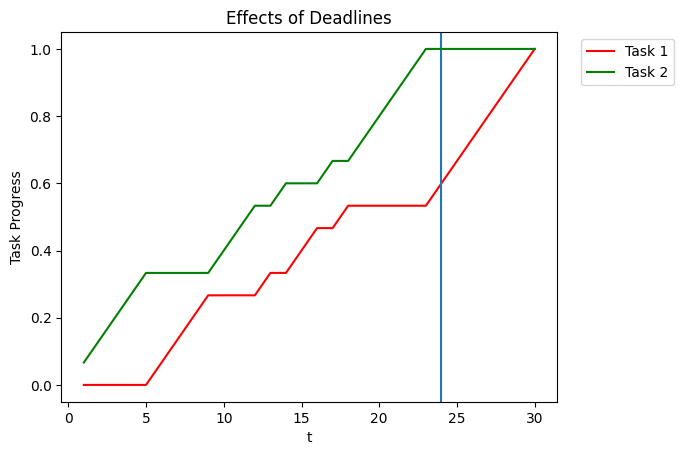

In [ ]:
# Effects of Task Deadlines Average over 100 samples
t1done_t_N = []
t2done_t_N = []
N_STEPS_AVERG = 1  # 100

for sampl in range(N_STEPS_AVERG):
  a = 11/2

  tau_task = 0.5 #0.02
  tau_se_c = 0.0001
  c = 0.5
  m = 0.01

  T = 30

  u_t = []
  eel2 = 0
  b2 = 1
  eel1 = 0
  b1 = 1
  se1o = [0.5]
  se2o = [0.5]

  t1done = 0
  t2done = 0

  t1done_t = []
  t2done_t = []

  use_perc_ = False

  cu_perc1 = 0
  cu_perc2 = 0

  for t in range(1, T+1):

    if t == int(0.8*T):
      tau_task = 0.002

      rand1 = random.uniform(0, .1)
      se1_change = [((m * ((T-t+1)/T - (1-t1done))) + rand1) * se_o for se_o in se1o]
      se1_change = np.array(se1_change)

      rand2 = random.uniform(0, .1)
      se2_change = [((m * ((T-t+1)/T - (1-t2done))) + rand2) * se_o for se_o in se2o]
      se2_change = np.array(se2_change)

      se1 = np.exp(se1_change/tau_se_c )  /   (np.exp(se1_change/tau_se_c)  +   np.exp(se2_change/tau_se_c))
      se2 = np.exp(se2_change/tau_se_c )  /   (np.exp(se1_change/tau_se_c)  +   np.exp(se2_change/tau_se_c))

    elif t < int(0.8*T):
      se1 = se1o
      se2 = se2o

    elif t > int(0.8*T):
      se1 = se1
      se2 = se2

    eel1, b1, u_el1, _, _, _, _ , cu_perc1 = rea_util(value_g=VALUE_G, se=[se1], a=a, cu_perc = cu_perc1, b=b1, c=c, t=t, T=T, eel=eel1, ext_fb=t1done, ret_util=True, use_perc=use_perc_)
    eel2, b2, u_el2, _, _, _, _ , cu_perc2 = rea_util(value_g=VALUE_G, se=[se2], a=a, cu_perc = cu_perc2, b=b2, c=c, t=t, T=T, eel=eel2, ext_fb=t2done, ret_util=True, use_perc=use_perc_)

    u_el1 = np.max(u_el1)
    u_el2 = np.max(u_el2)


    p1, p2 = bol([u_el1, u_el2], t=tau_task)

    if t1done > .9999:
      p1 = [0]
      p2 = [1]

    if t2done > .9999:
      p2 = [0]
      p1 = [1]

    draw = choice([0, 1], 1, p=[p1[0], p2[0]])


    if draw[0] == 0:
      t1done += 1/(T/2)
    if draw[0] == 1:
      t2done += 1/(T/2)

    t1done_t.append(t1done)
    t2done_t.append(t2done)

  t1done_t_N.append(t1done_t)
  t2done_t_N.append(t2done_t)

if N_STEPS_AVERG > 1:
  t1done_t_N = np.mean(t1done_t_N, 0)
  t2done_t_N = np.mean(t2done_t_N, 0)
else:
  t1done_t_N = np.reshape(t1done_t_N, [-1])
  t2done_t_N = np.reshape(t2done_t_N, [-1])

plt.plot(range(1, T+1), t1done_t_N, 'r', label='Task 1')
plt.axvline(x=24.)
plt.plot(range(1, T+1), t2done_t_N, 'g', label='Task 2')
plt.ylabel('Task Progress')
plt.xlabel('t')
plt.title("Effects of Deadlines")
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
plt.show()

Simulations

Vancouver, Thomson, and Williams, 2001

Mastermind is an analytic game in which winning is achieved by determining the color and position of four pegs in a row (i.e., the solution set).

se leaning rate = 0.1
se leaning noise = 0.1
Pearsons r value (correlation) (SE Strength, Performance): r=: 0.5549251135511412 p= 1.580807739243644e-42
Covariance (SE, performance): 0.2554130486645238
X M = 3.8945960412176546 SD= 0.5310161337887032
Y M = 7.202941176470588 SD= 0.8650647014624183
Linear reg (a*SE+b): a = 0.9040142043577384 b= 3.6821710349744143


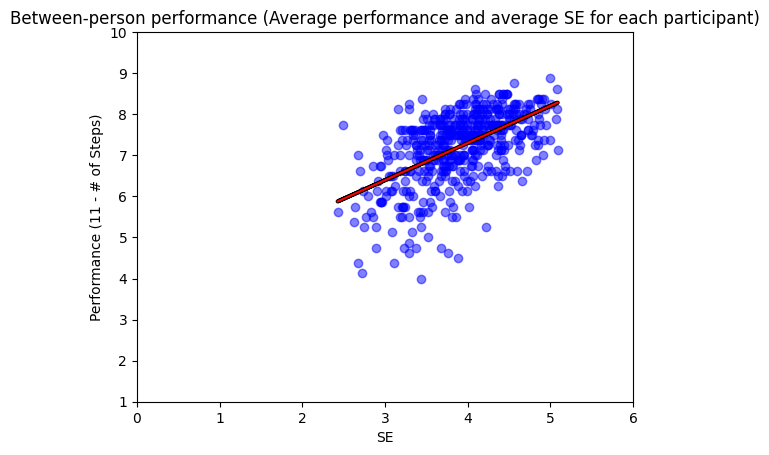

Pearsons r value (correlation) (SE Strength, Performance): r=: 0.2760215151584202 p= 3.016773127085939e-72
Covariance (SE, performance): 0.302108944045998


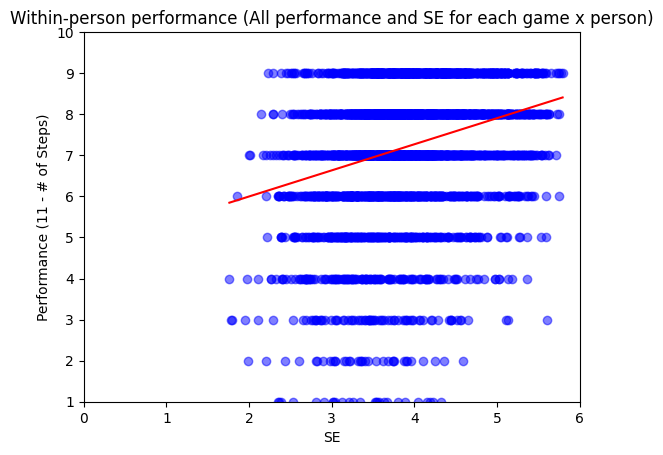

Pearsons r value (correlation) (Game #, Performance): r=: -0.967884198105663 p= 8.083069876058293e-05


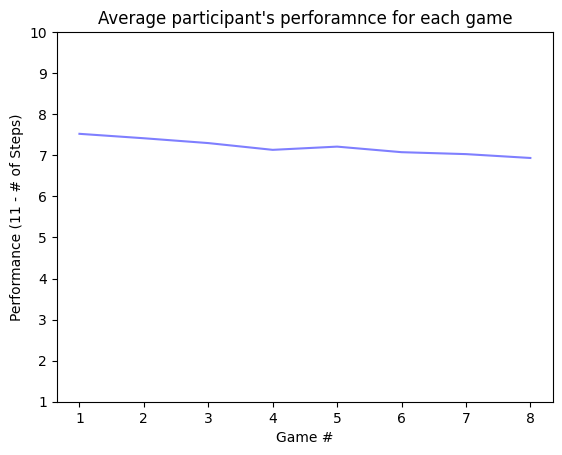

Pearsons r value (correlation) (Game #, SE): r=: 0.978722059098157 p= 2.3701302264083794e-05


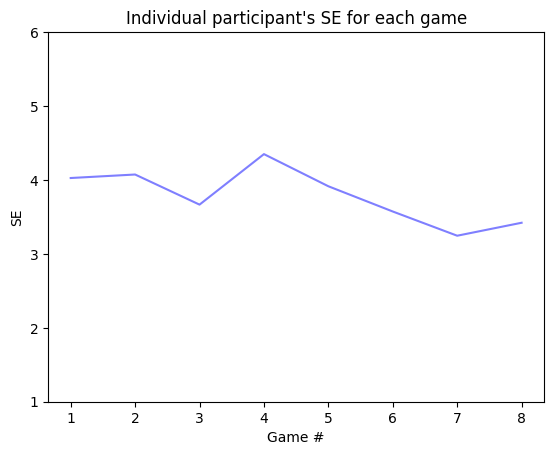

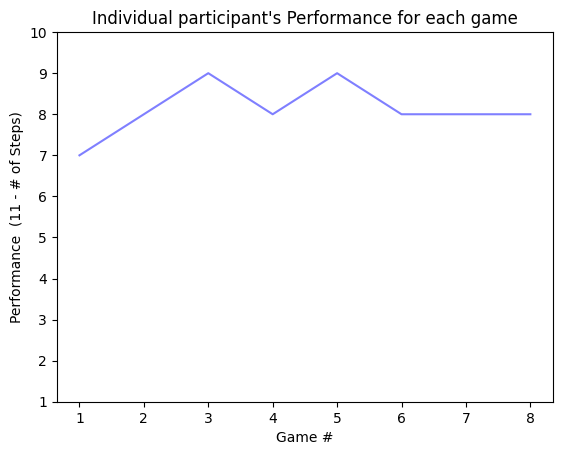

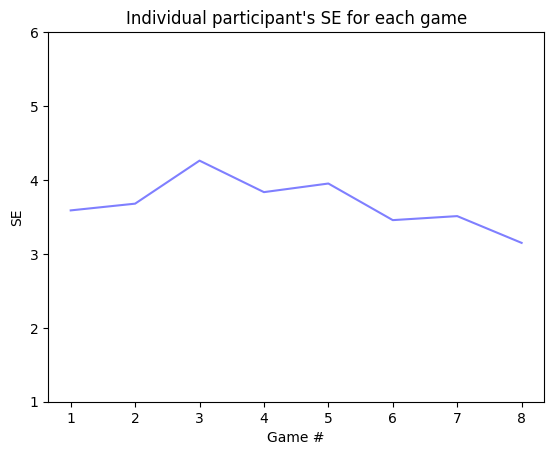

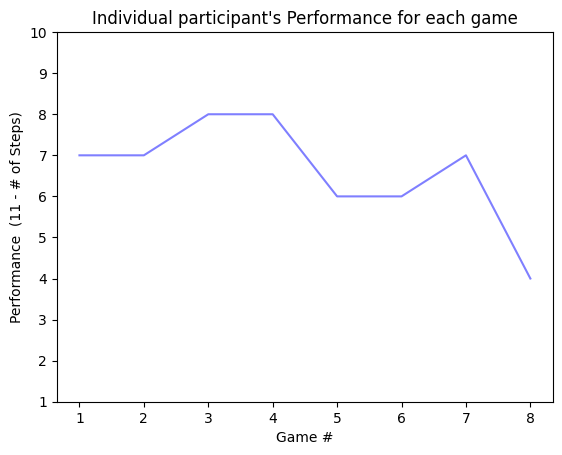

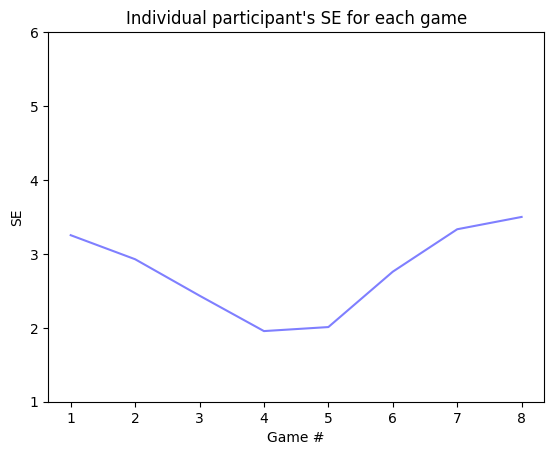

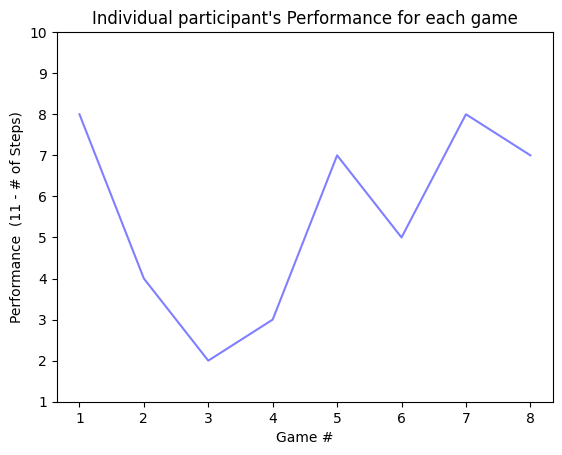

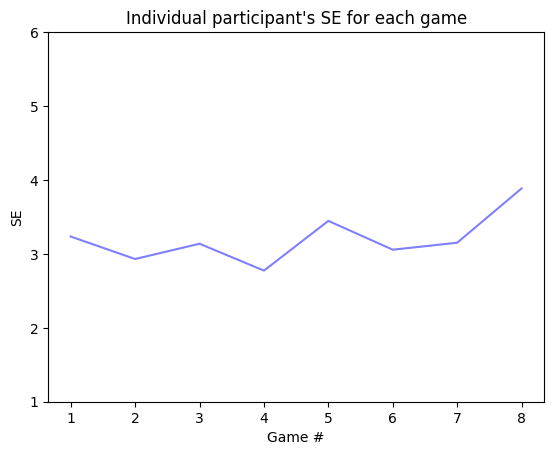

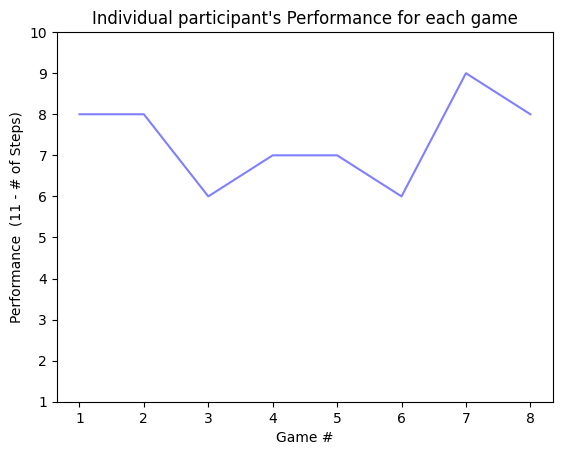

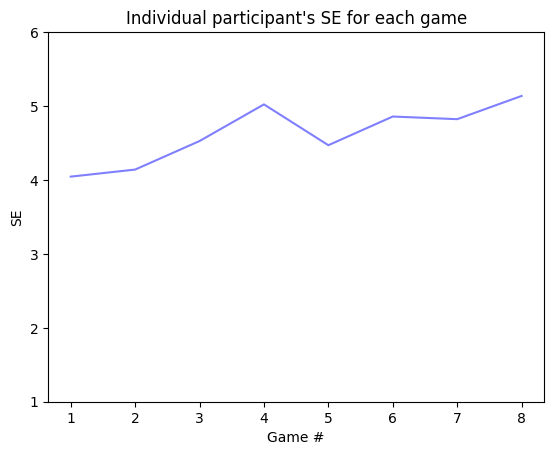

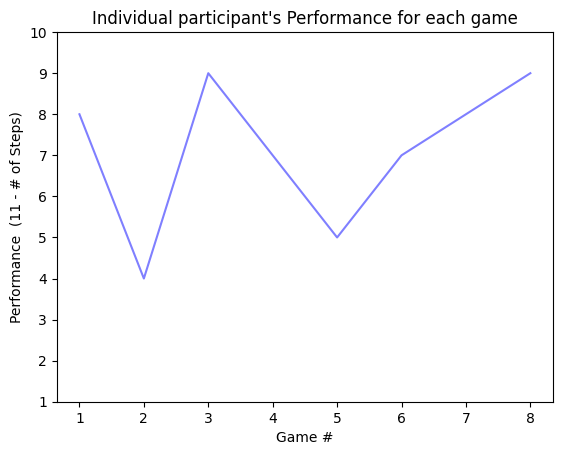

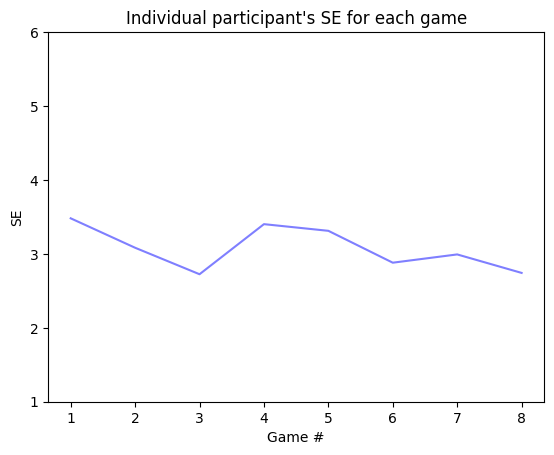

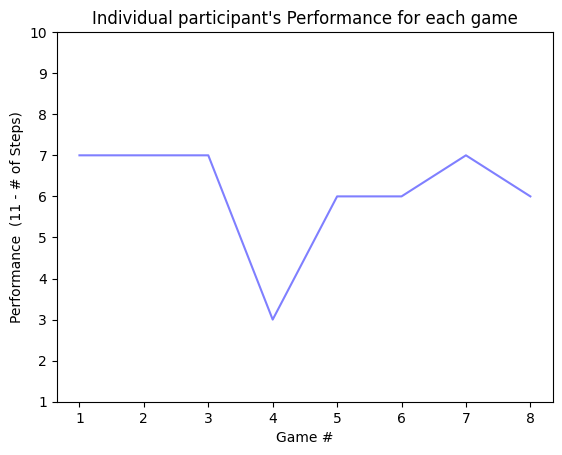

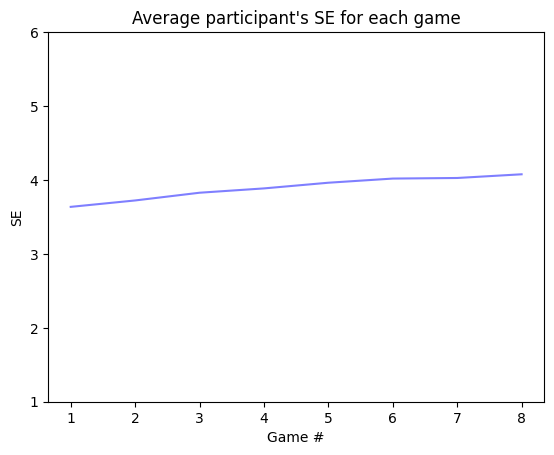

Pearsons r value (correlation) (SE Strength, Performance): r=: -0.9674850252608915 p= 8.385689549579522e-05
Covariance (SE, performance): -0.030290552403294122
X M = 3.8945960412176546 SD= 0.1464987268505426
Y M = 7.202941176470588 SD= 0.18699807868055532


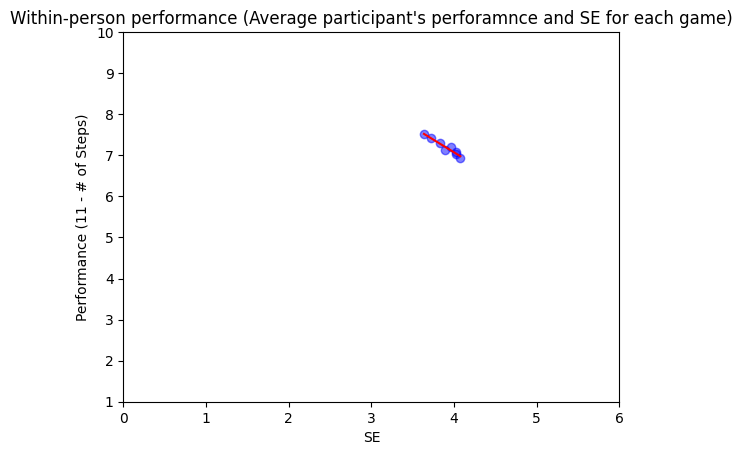

Pearsons r value (correlation) (SE Strength, Performance): r=: -0.137966319349658 p= 0.7445770910186804
Covariance (SE, performance): -0.03273434305503142


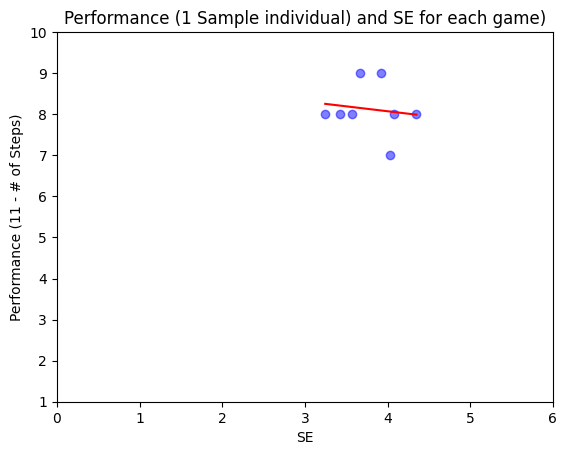

Pearsons r value (correlation) (SE Strength, Performance): r=: 0.7370639671826407 p= 0.03695479143216957
Covariance (SE, performance): 0.3255687365714412


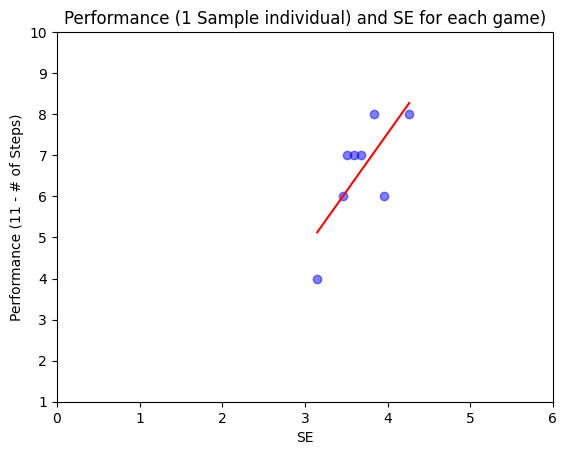

Pearsons r value (correlation) (SE Strength, Performance): r=: 0.5737070291478901 p= 0.1370297876042953
Covariance (SE, performance): 0.7925737415659713


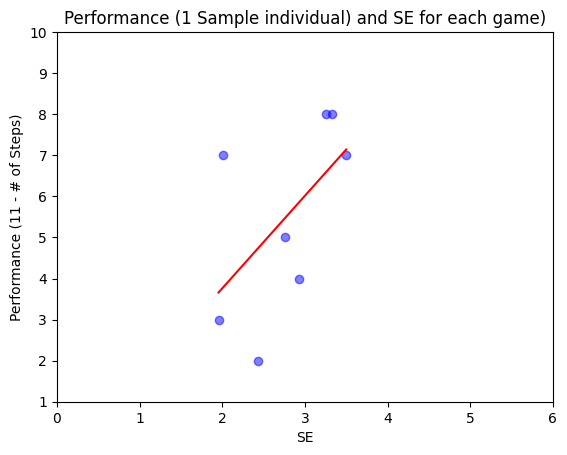

Pearsons r value (correlation) (SE Strength, Performance): r=: 0.2184647450058132 p= 0.6032252829805849
Covariance (SE, performance): 0.07899653484293166


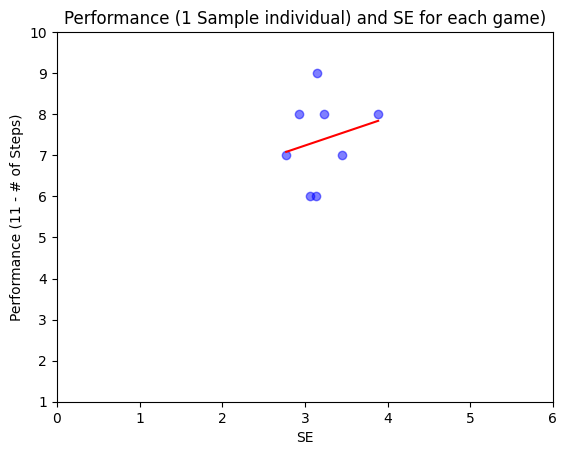

Pearsons r value (correlation) (SE Strength, Performance): r=: 0.4359094144295469 p= 0.28030542570204076
Covariance (SE, performance): 0.31489545871254004


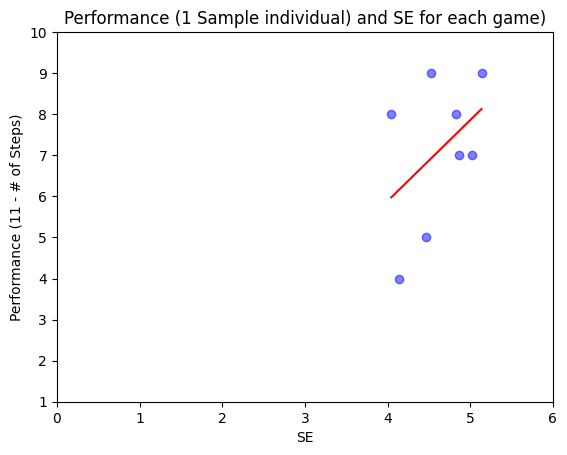

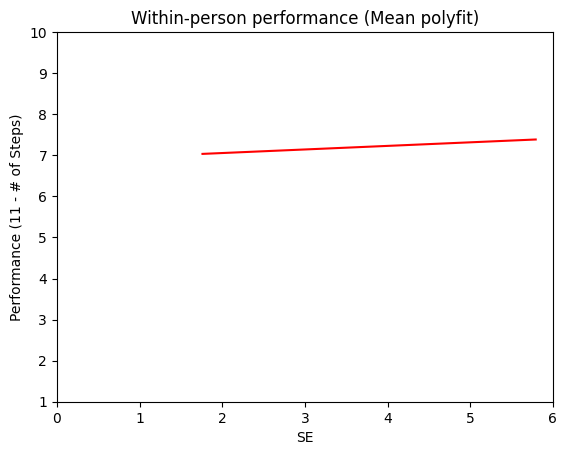

In [ ]:
reg = linear_model.LinearRegression()

N_p = 51*10 # n participants
N_g = 8  # n test trials/games
N_t = 10 # n tries per game

P_mu = 6.56 # Table 1 mean performance
P_sd = 1.10 # Table 1 performance SD


EL_J = np.arange(0.1,1.01,.1)
EL_J = np.reshape(np.array(list(EL_J)), newshape=(-1, 1))
N_el = EL_J.shape[0]
EL_J_FLT = np.reshape(EL_J, -1)

tau = 0.01
c = 0.5  # c = 0.5
VALUE_G = np.random.normal(loc=.5, scale=.15, size=(N_p))
VALUE_G = np.clip(VALUE_G, 0., 1.)
a = 11/2

def plot_se_perf(se, perf):
  x = se
  y = perf

  plt.scatter(x, y, c='b', alpha=0.5)

  z = np.polyfit(x, y, 1)
  p = np.poly1d(z)
  plt.plot(x,p(x),"r")

  plt.ylabel('Performance (# of Steps)')
  plt.xlabel('SE')

  plt.show()

# DATA
P_data = np.random.normal(loc=P_mu, scale=P_sd, size=(N_p))
P_data = np.clip(P_data, 1, N_t)
P_data = np.round(P_data)

SE_mu = 3.65 # Reverse of reverse value from Table 1 mean SE strength max = 6, min = 1
SE_sd = 0.75 # Table 1 SE strength SD
SE_orig = np.random.normal(loc=SE_mu, scale=SE_sd, size=(N_p, N_t))
SE_orig = np.clip(SE_orig, 1, 6)
SE_norm = (SE_orig - 1) / (6 - 1)  #
SE_norm = np.sort(SE_norm, axis=1)

SE_data = SE_norm #* SE_a


learn_noise_options = np.array([-1., 0., 1.])

for learn_noise_x in [.1]: # [0.001, 0.1, 0.2, 0.3, 0.4, 0.5]:
  for se_learn_rate in [0.1]: #[0.1, 0.2, 0.3, 0.4, 0.5, 0.8]:
    print('se leaning rate =', se_learn_rate)
    print('se leaning noise =', learn_noise_x)

    PERF_DATA = np.zeros(shape=[N_g, N_p])
    el_exprmt = np.zeros(shape=[N_g, N_p, N_t])
    se_exprmt = np.zeros(shape=[N_g, N_p, N_t])
    withinp_se_data = np.zeros(shape=[N_g, N_p])

    learn_noise_options = [-1*learn_noise_x, 0, learn_noise_x]
    learn_noise2 = np.random.choice(learn_noise_options, size=[N_g, N_p], p=[1/3, 1/3, 1/3])

    for j in range(N_g):
      for i in range(N_p):

        ext_fb_ = 0
        eel1 = None
        el1 = None
        task_done_P = 0
        el_partcpnt = []
        cu_perc1 = 0

        SE_P_all = SE_data[i, :]
        withinp_se_data[j, i] = np.mean(SE_P_all, axis=0)

        for t in range(N_t):
          se_p = [SE_data[i, t]]

          is_done = choice([0, 1], 1, p=[1-task_done_P, task_done_P])
          is_done = is_done[0]

          val_g = VALUE_G[i]

          if is_done == 1:
            ext_fb_ = 1
            _, b1, _, u_b1, _, _, el1 , cu_perc1 = rea_util(value_g=val_g, se=se_p, el=el1, cu_perc = cu_perc1, el_j=EL_J_FLT, a=a, b=1, c=c, t=t, T=N_t, ext_fb=ext_fb_, ret_util=True)

            for k in range(t, N_t):
              SE_data[i, k] = (1 - se_learn_rate) * SE_data[i, k] + se_learn_rate * 1 + learn_noise2[j, i]  # 6 is for 'extremely likely' see paper SE strength

            SE_data = np.clip(SE_data, 0, 1)

          else:
            ext_fb_ = 0
            SE_data[i, t] = (1 - se_learn_rate) * SE_data[i, t] + se_learn_rate * 0 + learn_noise2[j ,i]# 1 is for 'unlikely'
            SE_data = np.clip(SE_data, 0, 1)
            _, b1, _, u_b1, _, _, el1, cu_perc1 = rea_util(value_g=val_g, se=se_p, el=el1,  cu_perc = cu_perc1, el_j=EL_J_FLT, a=a, b=1, c=c, t=t, T=N_t, ext_fb=ext_fb_, ret_util=True)

            task_done_P = true_tanh(min(.8*(task_done_P + el1[0][0]), 1))

            u_b12p = np.reshape(u_b1, [-1])
            el_slctd = choice(EL_J_FLT, 1, p=u_b12p)


          el_partcpnt.append(el1)

          if is_done == 1:
            PERF_DATA[j, i] = t+1
            break

          if t == (N_t-1):
            PERF_DATA[j, i] = t+1


    PERF_DATA = np.clip(PERF_DATA, a_min=1, a_max = 10)


    PERF_DATA1 = np.mean(PERF_DATA, axis=0)
    SE_strength1 = np.mean(withinp_se_data, axis=0)

    x = SE_strength1 * 5 + 1
    y = 11 - PERF_DATA1

    xra = np.reshape(x, (-1, 1))
    yra = np.reshape(y, (-1, 1))

    reg.fit(xra, yra)
    y_pred = reg.predict(xra)
    plt.plot(xra, y_pred, 'black',  linewidth=3)



    print('Pearsons r value (correlation) (SE Strength, Performance): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
    print('Covariance (SE, performance):', np.cov(np.stack((x, y), axis=0))[0, 1])

    plt.scatter(x, y, c='b', alpha=0.5)
    print('X M =', np.mean(x), 'SD=', np.std(x))
    print('Y M =', np.mean(y), 'SD=', np.std(y))

    z = np.polyfit(x, y, 1)
    x = np.linspace(np.min(x),np.max(x),100)
    y = z[0]*x+z[1]
    plt.plot(x, y, 'r')

    print('Linear reg (a*SE+b): a =', z[0], 'b=', z[1])

    plt.title('Between-person performance (Average performance and average SE for each participant)')
    plt.ylabel('Performance (11 - # of Steps)')
    plt.xlabel('SE')
    plt.xlim([0, 6])
    plt.ylim([1, 10])

    plt.show()



    SE_strength3 = np.reshape(withinp_se_data, -1)
    PERF_DATA3 = np.reshape(PERF_DATA, -1)

    x = SE_strength3 * 5 + 1
    y = 11-PERF_DATA3

    # OLS analysis
    #
    # results = sm.OLS(y, x).fit()
    # print(results.summary())

    print('Pearsons r value (correlation) (SE Strength, Performance): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
    print('Covariance (SE, performance):', np.cov(np.stack((x, y), axis=0))[0, 1])

    plt.scatter(x, y, c='b', alpha=0.5)

    z = np.polyfit(x, y, 1)
    x = np.linspace(np.min(x),np.max(x),100)
    y = z[0]*x+z[1]
    plt.plot(x,y, 'r')

    plt.title('Within-person performance (All performance and SE for each game x person)')
    plt.ylabel('Performance (11 - # of Steps)')
    plt.xlabel('SE')
    plt.xlim([0, 6])
    plt.ylim([1, 10])

    plt.show()



    SE_strength4 = np.mean(withinp_se_data, axis=1)
    PERF_DATA4 = np.mean(PERF_DATA, axis=1)

    x = SE_strength4 * 5 + 1
    y = 11 - PERF_DATA4


    x_game_ind = np.array(range(len(y))) + 1

    print('Pearsons r value (correlation) (Game #, Performance): r=:', pearsonr(x_game_ind, y)[0], 'p=', pearsonr(x_game_ind, y)[1])

    plt.plot(x_game_ind, y, c='b', alpha=0.5)
    plt.title("Average participant's perforamnce for each game")
    plt.ylabel('Performance (11 - # of Steps)')
    plt.xlabel('Game #')
    plt.ylim([1, 10])
    plt.show()

    print('Pearsons r value (correlation) (Game #, SE): r=:', pearsonr(x_game_ind, x)[0], 'p=', pearsonr(x_game_ind, x)[1])


    x_se = withinp_se_data * 5 + 1
    y_per = PERF_DATA
    r_s = []
    p_s = []
    lin_reg_coefs = []
    lin_reg_coefs2 = []
    lin_reg_coefs2b = []

    reg = linear_model.LinearRegression(fit_intercept = False)

    for part_ind in range(x_se.shape[1]):
        x_se_p = x_se[:, part_ind]
        y_per_p = 11 - y_per[:, part_ind]

        if part_ind < 6:
          plt.plot(x_game_ind, x_se_p, c='b', alpha=0.5)
          plt.title("Individual participant's SE for each game")
          plt.ylabel('SE')
          plt.xlabel('Game #')
          plt.ylim([1, 6])
          plt.show()


          plt.plot(x_game_ind, y_per_p, c='b', alpha=0.5)
          plt.title("Individual participant's Performance for each game")
          plt.ylabel('Performance  (11 - # of Steps)')
          plt.xlabel('Game #')
          plt.ylim([1, 10])
          plt.show()

    plt.plot(x_game_ind, x, c='b', alpha=0.5)
    plt.title("Average participant's SE for each game")
    plt.ylabel('SE')
    plt.xlabel('Game #')
    plt.ylim([1, 6])

    plt.show()

    print('Pearsons r value (correlation) (SE Strength, Performance): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
    print('Covariance (SE, performance):', np.cov(np.stack((x, y), axis=0))[0, 1])

    # # OLS analysis
    # # X = sm.add_constant(x)
    # X = x
    # results = sm.OLS(y, X).fit()
    # print(results.summary())

    # Regression analysis
    # X = np.reshape(x, [-1, 1])
    # Y = np.reshape(y, [-1, 1])
    # reg.fit(X, Y)
    # print('Lin. reg. coef.', reg.coef_)


    print('X M =', np.mean(x), 'SD=', np.std(x))
    print('Y M =', np.mean(y), 'SD=', np.std(y))

    plt.scatter(x, y, c='b', alpha=0.5)

    z = np.polyfit(x, y, 1)
    x = np.linspace(np.min(x),np.max(x),100)
    y = z[0]*x+z[1]
    plt.plot(x,y, 'r')

    plt.title("Within-person performance (Average participant's perforamnce and SE for each game)")
    plt.ylabel('Performance (11 - # of Steps)')
    plt.xlabel('SE')
    plt.xlim([0, 6])
    plt.ylim([1, 10])

    plt.show()



    # Individual Performance
    SE_strength2 = withinp_se_data
    PERF_DATA2 = PERF_DATA

    for i in range(5):
      x = np.reshape(SE_strength2[:, i], -1)
      y = np.reshape(PERF_DATA2[:, i], -1)

      x = x * 5 + 1
      y = 11 - y

      print('Pearsons r value (correlation) (SE Strength, Performance): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
      print('Covariance (SE, performance):', np.cov(np.stack((x, y), axis=0))[0, 1])

      plt.scatter(x, y, c='b', alpha=0.5)

      z = np.polyfit(x, y, 1)
      x = np.linspace(np.min(x),np.max(x),100)
      y = z[0]*x+z[1]
      plt.plot(x,y, 'r')

      plt.title("Performance (1 Sample individual) and SE for each game)")
      plt.ylabel('Performance (11 - # of Steps)')
      plt.xlabel('SE')
      plt.xlim([0, 6])
      plt.ylim([1, 10])

      plt.show()



    SE_strength2 = withinp_se_data
    PERF_DATA2 = PERF_DATA
    polyfit_y = []
    lin_reg_coefs = []
    min_x = 100
    max_x = -1

    for i in range(SE_strength2.shape[1]):
      x = np.reshape(SE_strength2[:, i], -1)
      y = np.reshape(PERF_DATA2[:, i], -1)

      x = x * 5 + 1
      y = 11 - y

      X = np.reshape(x, [-1, 1])
      Y = np.reshape(y, [-1, 1])

      # reg.fit(X, Y)
      # lin_reg_coefs.append(reg.coef_)

      if np.min(x) < min_x:
        min_x = np.min(x)

      if np.max(x) > max_x:
        max_x = np.max(x)

      z = np.polyfit(x, y, 1)

      x2 = np.linspace(np.min(x),np.max(x),100)

      y2 = z[0]*x2+z[1]

      polyfit_y.append(y2)

    polyfit_y = np.array(polyfit_y)
    polyfit_y_avg = np.mean(polyfit_y, axis=0)

    x3 = np.linspace(min_x,max_x,100)
    plt.plot(x3,polyfit_y_avg, 'r')

    plt.title('Within-person performance (Mean polyfit)')
    plt.ylabel('Performance (11 - # of Steps)')
    plt.xlabel('SE')
    plt.xlim([0, 6])
    plt.ylim([1, 10])
    plt.show()

    # print('Average lin. reg. coeff.', np.mean(lin_reg_coefs))

    # # OLS analysis
    # # X = sm.add_constant(x)
    # X = x
    # results = sm.OLS(y, X).fit()
    # print(results.summary())


Vancouver et al., 2008
Participants were instructed to click on squares that jumped about rapidly and randomly in a specific area on the screen

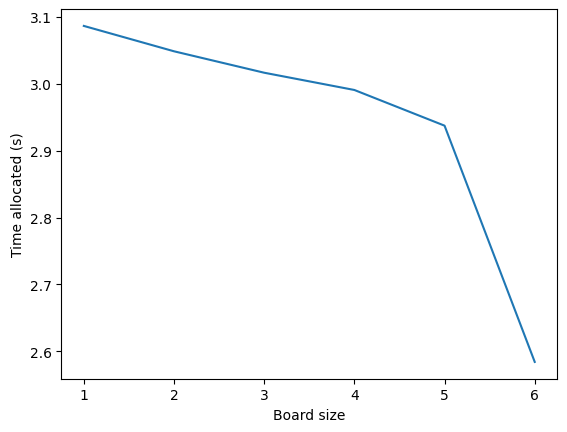

Ave games per participant: 94   94.10089285714285   94.10089285714285
Success prob: 0.046375
Original data, P (mu, sd): 33.39 9.83
Generated data, P (mu, sd): 33.37824213928483 9.780577261466169
SE generated high mastery: 3.389756282047254 1.4693472989027245
SE generated low mastery: 2.932681357604648 1.3347034042909023
Stat dif low high Ttest_indResult(statistic=-5.444052903521685, pvalue=6.399071251611692e-08)
Generated SE_norm, SE (mu, sd): 0.3161218819825951 0.14221240110299035
SE_gen: M= 3.1551229921737534 SD= 1.9806541706333907
n_g_sim per participant: 248.13482142857143
simul suc ave#, prob: 34.4875 0.047899305555555556
Original suc #: 33.39
Ave games per participant: 94   94.10089285714285   94.10089285714285
Ave time alloc: 60.0
Ave time alloc (LOw MAs): 2.9892857142857143 1.8448459644786233
Ave time alloc (High mast): 2.8674313611892215 1.908440702193189
Stat dif time alloc low high Ttest_indResult(statistic=1.509571917372553, pvalue=0.13115380549675015)
Correlations sim_b_sz

<ipython-input-11-cea1851975ca>:351: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat2, p_val2 = stats.ttest_ind(em0_se, em1_se, equal_var=False)


bsz ta 1 2.992308830054726
bsz ta 2 2.980075619185182
bsz ta 3 2.9590935035832824
bsz ta 4 2.905258071970254
bsz ta 5 2.8628321390069122
bsz ta 6 2.5045089114807095


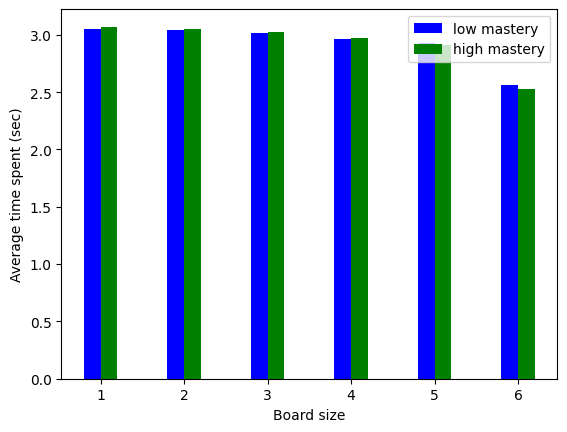

Simulated direction : mu= 0.9798156792508709 sd= 0.14063041614467847
Original direction : mu= 0.91 sd= 0.14
Pearson's r value (correlation) (board size, Magnitude): r=: -0.8284919828826125 p= 0.04160004574708102


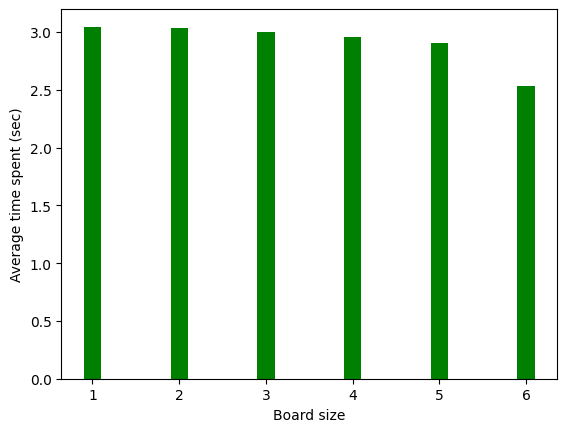

Pearson's r value (correlation) (board size, Effort): r=: -0.8284919828826125 p= 0.04160004574708102


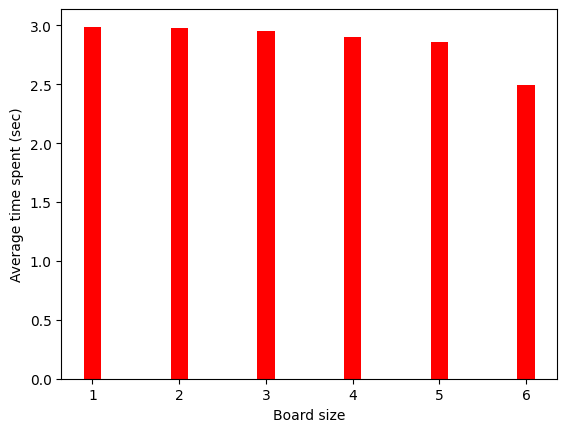

t-test comparing Performance in high vs. low enacted groups (Table 3): Ttest_indResult(statistic=2.7255685509203027, pvalue=0.006519330828136672)
Pearsons r value (correlation) (SE, Magnitude): r=: -0.1987242204222976 p= 1.9436939301509976e-11


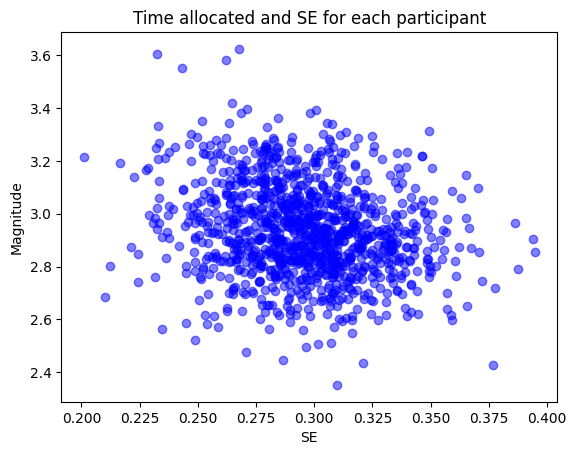

Pearsons r value (correlation) (SE, EL): r=: -0.09376845899687926 p= 0.0016807764251915614


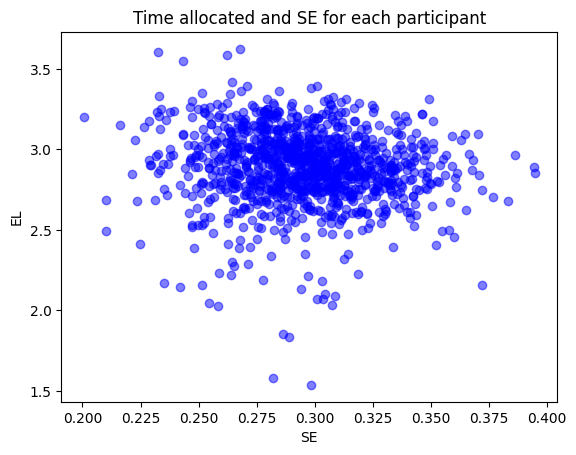

Pearsons r value (correlation) (board size, Direction): r=: 0.012795837767840124 p= 9.426988296675685e-12
Table 2
Enacted mastery M: 0.5 SD: 0.5
Self-efficacy M: 0.2956121717973208 SD: 0.029026000679767468 1: r= 0.04368189782739393 p= 1.9051986706898776e-117
Magnitude: M: 2.9372168488408072 SD: 0.17666000819674438 1: r= 6.392374206321729e-05 p= 0.9731174181970221 2: r= -0.1526840962735676 p= 0.0
Direction M: 0.9798156792508709 SD: 0.14063041614467847 1: r= 0.009333646024096962 p= 6.662503137681055e-07 2: r= 0.02829264764479285 p= 2.5164753044781494e-51 3: r= 0.2156810694493138 p= 0.0
Performance M: 34.4875 SD: 5.231073452388689 1: r= -0.08124527477356114 p= 0.00651933082813667 2: r= 0.49878359264236316 1.7011391785528108e-71 3: -0.341979858931427 p= 4.430570089581794e-32 4: r= 0.05698792446126402 p= 1.1791422134651153e-202
ALL Pearsons r value (correlation) (board size, Magnitude): r=: -0.07788251263348553 p= 0.0
NO EM Group Pearsons r value (correlation) (board size, Magnitude): r=: -

In [ ]:
y_xx = [3.0868090288348626, 3.048852508847732, 3.016781364652758, 2.990955317537596, 2.9375587162176924, 2.5840424380210023]
x = np.array([1, 2, 3, 4, 5, 6])
plt.plot(x, y_xx)
plt.ylabel('Time allocated (s)')
plt.xlabel('Board size')
plt.show()


P_mu = 33.39
P_sd = 9.83
P_max = 4*3*60.0  # 4 trials 3x60 sec each
N_sec = 4*3*60  # 4 trials 3x60 sec each
N_iter = 4*3
Succ_prob = P_mu/P_max

N_p = 112*10 # n participants
N_p_2 = int(N_p/2)
N_p = N_p_2 * 2
N_tr = 4 # n trials
N_sz = 6 # number of board sizes

# Ave n games inferred! from the paper
n_games = 0
n_games2 = 0
n_games_per_p = []

for i in range(N_p):
  t_spent_game = 0
  n_games = 0
  for j in range(4):
    t_spent_game = 0
    for k in range(3):
      t_spent_game = 0
      for l in range(60):
        t_spent_game = t_spent_game + 1
        done = choice([False, True], 1, p=[1-Succ_prob, Succ_prob])
        if done:
          n_games = n_games + 1
          n_games2 = n_games2 + 1
          t_spent_game = 0
        else:
          if t_spent_game == 10 or l == 59:
            n_games = n_games + 1
            n_games2 = n_games2 + 1
            t_spent_game = 0

  n_games_per_p.append(n_games)


print('Ave games per participant:', int(n_games2/N_p), ' ', n_games2/N_p, ' ', np.mean(n_games_per_p))


Mag_mu = 6.98
Mag_sd = 1.61

P = np.random.normal(loc=P_mu, scale=P_sd, size=(N_p))
P = np.clip(P, 0., P_max)

print('Success prob:', Succ_prob)
print('Original data, P (mu, sd):', P_mu, P_sd)
print('Generated data, P (mu, sd):', np.mean(P), np.std(P))

EL_J_FLT = np.array([0., 0.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])

# p.41-42:
# “Specifically, the average self-efficacy for those in the high enacted mastery condition was
# 3.39 (SD  1.41). For those in the low enacted mastery condition, the average self-efficacy was 2.88 (SD  1.29).”

SE_norm = np.zeros(shape=[N_p])

SE_mu_low = 2.88
SE_sd_low = 1.29

SE_mu_hig = 3.39
SE_sd_hig = 1.41

SE_orig_low = np.random.normal(loc=SE_mu_low, scale=SE_sd_low, size=(N_p_2))
SE_orig_low = np.clip(SE_orig_low, 0., 100.0/10)  # "/10" -> average per each time level

SE_orig_hig = np.random.normal(loc=SE_mu_hig, scale=SE_sd_hig, size=(N_p_2))
SE_orig_hig = np.clip(SE_orig_hig, 0., 100.0/10)  # "/10" -> average per each time level

SE_norm[:N_p_2] = SE_orig_low
SE_norm[N_p_2:] = SE_orig_hig

SE_norm = SE_norm / 10
print("SE generated high mastery:", np.mean(SE_orig_hig), np.std(SE_orig_hig))
print("SE generated low mastery:", np.mean(SE_orig_low), np.std(SE_orig_low))
print("Stat dif low high", scipy.stats.ttest_ind(SE_orig_low, SE_orig_hig))

print('Generated SE_norm, SE (mu, sd):', np.mean(SE_norm.flatten()), np.std(SE_norm.flatten()))

SE_norm_lo_mu = np.mean(SE_norm[:N_p_2])
SE_norm_lo_sd = np.std(SE_norm[:N_p_2])

SE_norm_hi_mu = np.mean(SE_norm[N_p_2:])
SE_norm_hi_sd = np.std(SE_norm[N_p_2:])

SE_norm_lo = np.random.normal(loc=SE_norm_lo_mu, scale=SE_norm_lo_sd, size=(N_p_2, N_sz))
SE_norm_lo = np.sort(SE_norm_lo, axis=1)

SE_norm_hi = np.random.normal(loc=SE_norm_hi_mu, scale=SE_norm_hi_sd, size=(N_p_2, N_sz))
SE_norm_hi = np.sort(SE_norm_hi, axis=1)

SE_norm2 = np.zeros(shape=[N_p, N_sz])
SE_norm2[:N_p_2, :] = SE_norm_lo
SE_norm2[N_p_2:, :] = SE_norm_hi
SE_norm = np.zeros(shape=[N_p, N_sz, EL_J_FLT.shape[0]])

for pi in range(N_p):
  for ni in range(N_sz):
    SE_norm_mu = SE_norm2[pi, ni]

    if pi < N_p_2:
      SE_norm_sd = SE_norm_lo_sd
    else:
      SE_norm_sd = SE_norm_hi_sd

    SE_norm[pi, ni, :] = np.random.normal(loc=SE_norm_mu, scale=SE_norm_sd, size=(EL_J_FLT.shape[0]))

SE_norm = np.sort(SE_norm, axis=2)

SE_gen = np.reshape(SE_norm, (-1)) * 10
SE_gen_mu = np.mean(SE_gen)
SE_gen_sd = np.std(SE_gen)
print('SE_gen: M=', SE_gen_mu, 'SD=', SE_gen_sd)

enac_mast = np.zeros((N_p))
enac_mast[N_p_2:] = np.ones_like(SE_orig_hig)

VALUE_G = np.random.normal(loc=.5, scale=.15, size=(N_p))
VALUE_G = np.clip(VALUE_G, 0., 1.)

n_g_sim = 0
n_suc_sim = 0

em_p = np.zeros(shape=N_p)
em_p[N_p_2:] = np.ones(shape=N_p_2)


el1 = None
N_t = 10
ext_fb_ = None
time_a = 0


tau = .1
a = 91/2
c = .5

se_learn_rate = 0.1
learn_noise = 0.01

sim_ra = np.zeros(shape=[N_p, N_sz])  # resources alloc
sim_gp = np.zeros(shape=[N_p, N_sz])  # games played for different game sizes
sim_ga = np.zeros(shape=[N_p, N_sz])  # games available for different game sizes
sim_se = np.zeros(shape=N_p)
sim_se3 = np.zeros(shape=N_p)
sim_el = np.zeros(shape=N_p)
sim_el2 = np.zeros(shape=N_p)
sim_dir_0 = 0
sim_dir_1 = 0
sim_dir = []
sim_em = []
sim_em2 = []
sim_b_sz = []
sim_b_sz_2 = []
sim_time_a = []
sim_time_a_p = np.zeros(shape=N_p)
sim_time_a2 = []
sim_se_t = [] # SE for each trial when time allocated > 0
sim_se2 = []
sim_p_p = np.zeros(shape=N_p)  # performance as defined in the paper
sim_p2 = []
sim_p3 = []
sim_enac_mast = []


for p_i in range(N_p):
  val_g = VALUE_G[p_i]
  el1 = None
  N_t = 10
  ext_fb_ = -1
  cu_perc1 = 0

  for iter_i in range (N_tr):

    s = 0
    while True:

      b_size = np.random.randint(6, size=1)[0] + 1  # board size
      task_done_P = tanh(b_size * .2) / 15.0
      se_p = np.mean(SE_norm[p_i, b_size-1, :], axis=0)  # mean of a vector SE_P = SE_norm[p_i, b_size-1]


      _, b1, _, u_b1, _, _, el1 , cu_perc1 = rea_util(value_g=val_g, el=el1, se=[se_p], cu_perc= cu_perc1, el_j=EL_J_FLT, a=a, b=1, c=c, t=0, T=N_t, ext_fb=ext_fb_, ret_util=True)
      U_BOL_FLT = np.reshape(u_b1, -1)
      time_alloc = int(np.random.choice(EL_J_FLT, 1, p=U_BOL_FLT) * 10)

      sim_ga[p_i, b_size-1] += 1

      sim_se3[p_i] += se_p
      sim_el2[p_i] += time_alloc

      if time_alloc > 0:

        sim_em.append(em_p[p_i])
        sim_em2.append(em_p[p_i])
        sim_dir.append(1)
        sim_b_sz.append(b_size)
        sim_b_sz_2.append(b_size)
        sim_time_a.append(time_alloc)
        sim_time_a2.append(time_alloc)
        sim_time_a_p[p_i] += time_alloc
        sim_se_t.append(se_p)
        sim_se2.append(se_p)
        sim_enac_mast.append(enac_mast[p_i])

        sim_dir_1 += 1
        sim_se[p_i] += se_p
        sim_el[p_i]  += time_alloc

        if s + time_alloc > 60*3:
            time_alloc = 60*3 - s

        sim_ra[p_i, b_size-1] += time_alloc
        sim_gp[p_i, b_size-1] += 1
        time_a += time_alloc

        for t in range(time_alloc):
          is_done = choice([False, True], 1, p=[1-task_done_P, task_done_P])
          is_done = is_done[0]

          if is_done:
            sim_p_p[p_i] += 1

            break

        s += time_alloc

        n_g_sim += 1

        # SE learning
        for b_szs in range(b_size-1):
          SE_norm[p_i, b_szs, :] = (1 - se_learn_rate) * SE_norm[p_i, b_szs, :] + se_learn_rate * is_done + learn_noise

        if is_done:
          n_suc_sim = n_suc_sim + 1
          sim_p2.append(1)
          ext_fb_ = 1

        else:
          ext_fb_ = -1
          sim_p2.append(0)



        if s >= 60*3:

          break
      else:
        sim_dir_0 += 1
        sim_dir.append(0)
        sim_b_sz.append(b_size)
        sim_time_a2.append(time_alloc)
        sim_em2.append(em_p[p_i])
        sim_se2.append(se_p)
        sim_p2.append(0)


print('n_g_sim per participant:', n_g_sim/N_p)
print('simul suc ave#, prob:', n_suc_sim/(N_p), n_suc_sim/(N_p*N_sec))
print('Original suc #:', P_mu)
print('Ave games per participant:', int(n_games2/N_p), ' ', n_games2/N_p, ' ', np.mean(n_games_per_p))
print('Ave time alloc:', time_a/(N_p*N_iter))


print('Ave time alloc (LOw MAs):', np.mean(sim_time_a2[:N_p_2]), np.std(sim_time_a2[:N_p_2]))
print('Ave time alloc (High mast):', np.mean(sim_time_a2[N_p_2:]), np.std(sim_time_a2[N_p_2:]))
print("Stat dif time alloc low high", scipy.stats.ttest_ind(sim_time_a2[:N_p_2], sim_time_a2[N_p_2:]))
print("Correlations sim_b_sz , SE", pearsonr(sim_se2, sim_b_sz)[0], 'p=', pearsonr(sim_se2, sim_b_sz)[1])
print("Correlations time_alloc , sim_b_sz", pearsonr(sim_time_a2, sim_b_sz)[0], 'p=', pearsonr(sim_time_a2, sim_b_sz)[1])
print("Correlations sim_dir , sim_b_sz", pearsonr(sim_dir, sim_b_sz)[0], 'p=', pearsonr(sim_dir, sim_b_sz)[1])
print("Correlations mastery , time_alloc", pearsonr(sim_dir, sim_time_a2)[0], 'p=', pearsonr(sim_dir, sim_time_a2)[1])
print("Stat dif time alloc low high", scipy.stats.ttest_ind(sim_time_a2[:N_p_2], sim_time_a2[N_p_2:]))




sim_per_em1 = np.zeros(N_sz)
n1 = np.zeros(N_sz)
sim_per_em0 = np.zeros(N_sz)
n0 = np.zeros(N_sz)

stat_a_b_szs_em1 = []
stat_a_perf_em1 = []
stat_a_b_szs_em0 = []
stat_a_perf_em0 = []

em0_sim_se2 = []
em1_sim_se2 = []
sim_ta_xx = []
sim_b_sz_xx = []

for i in range(len(sim_time_a2)):
  if sim_dir[i] == 1:
    sim_ta_xx.append(sim_time_a2[i])
    sim_b_sz_xx.append(sim_b_sz[i])
    if sim_em2[i] == 1:
      sim_per_em1[sim_b_sz[i]-1] += sim_time_a2[i]
      n1[sim_b_sz[i]-1] += 1
      stat_a_b_szs_em1.append(sim_b_sz[i])
      stat_a_perf_em1.append(sim_time_a2[i])
      em1_sim_se2.append(sim_se2[i])

    else:
      sim_per_em0[sim_b_sz[i]-1] += sim_time_a2[i]
      n0[sim_b_sz[i]-1] += 1
      stat_a_b_szs_em0.append(sim_b_sz[i])
      stat_a_perf_em0.append(sim_time_a2[i])
      em0_sim_se2.append(sim_se2[i])
  else:
    sim_ta_xx.append(0)
    sim_b_sz_xx.append(sim_b_sz[i])


x = np.array([1, 2, 3, 4, 5, 6])
y1 = sim_per_em1 / n1
y0 = sim_per_em0 / n0

em0_ = []
em1_ = []
em0_se = []
em1_se = []
p_vals = []
for bsz in x:
  ta_bsz = []
  for i in range(len(stat_a_b_szs_em0)):
    if stat_a_b_szs_em0[i] == bsz:
      em0_.append(stat_a_perf_em0[i])
      em0_se.append(em0_sim_se2[i])

  for j in range(len(stat_a_b_szs_em1)):
    if stat_a_b_szs_em1[j] == bsz:
      em1_.append(stat_a_perf_em1[j])
      em1_se.append(em0_sim_se2[i])

  t_stat, p_val = stats.ttest_ind(em0_, em1_, equal_var=False)
  t_stat2, p_val2 = stats.ttest_ind(em0_se, em1_se, equal_var=False)

  p_vals.append(p_val)

  for k in range(len(sim_ta_xx)):
    if sim_b_sz_xx[k] == bsz:
      ta_bsz.append(sim_ta_xx[k])

  print("bsz ta", bsz, np.mean(ta_bsz))


ax = plt.subplot(111)
ax.bar(x-0.1, y0, width=0.2, color='b', align='center', label='low mastery')
ax.bar(x+0.1, y1, width=0.2, color='g', align='center', label='high mastery')
for bsz in x:
  if p_vals[bsz-1] < 0.05:
    plt.text(bsz*.01, 0.9, '*', fontsize=20)
plt.ylabel('Average time spent (sec)')
plt.xlabel('Board size')
plt.legend(loc="upper right")
plt.show()


sim_ga_p = np.sum(sim_ga, axis=1)
sim_gp_p = np.sum(sim_gp, axis=1)

sim_se = sim_se / sim_gp_p
sim_time_a_p  = sim_time_a_p / sim_gp_p

sim_p = sim_ra / sim_gp
sim_p = np.mean(sim_p, axis=0)

sim_p3 = sim_ra / sim_ga
sim_p3 = np.mean(sim_p3, axis=0)


print('Simulated direction : mu=', np.mean(sim_dir), 'sd=', np.std(sim_dir))
print('Original direction : mu=', 0.91, 'sd=', 0.14)


x = np.array([1, 2, 3, 4, 5, 6])
y = sim_p
print("Pearson's r value (correlation) (board size, Magnitude): r=:", pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
ax = plt.subplot(111)
ax.bar(x, y, width=0.2, color='g', align='center')
plt.ylabel('Average time spent (sec)')
plt.xlabel('Board size')
plt.show()



x = np.array([1, 2, 3, 4, 5, 6])
y2 = sim_p3

print("Pearson's r value (correlation) (board size, Effort): r=:", pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
ax = plt.subplot(111)
ax.bar(x, y2, width=0.2, color='r', align='center', label='122')
plt.ylabel('Average time spent (sec)')
plt.xlabel('Board size')
plt.show()

y = sim_p_p
print("t-test comparing Performance in high vs. low enacted groups (Table 3):", stats.ttest_ind(y[:N_p_2], y[N_p_2:]))


x = sim_se
y = sim_el/sim_gp_p

print('Pearsons r value (correlation) (SE, Magnitude): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

plt.scatter(x, y, c='b', alpha=0.5)
plt.title("Time allocated and SE for each participant")
plt.ylabel('Magnitude')
plt.xlabel('SE')
plt.show()

x = sim_se3/sim_ga_p
y = sim_el2/sim_ga_p

print('Pearsons r value (correlation) (SE, EL): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

plt.scatter(x, y, c='b', alpha=0.5)
plt.title("Time allocated and SE for each participant")
plt.ylabel('EL')
plt.xlabel('SE')
plt.show()



x = sim_b_sz
y = sim_dir
print('Pearsons r value (correlation) (board size, Direction): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])


x = sim_se_t
y = sim_em
se_em_pears = pearsonr(x, y)

x = sim_time_a
y = sim_em
# print('Pearsons r value (correlation) (Magnitude, Enacted mastery): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
mag_em_pears = pearsonr(x, y)

x = sim_time_a
y = sim_se_t
# print('Pearsons r value (correlation) (Magnitude, SE): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
mag_se_pears = pearsonr(x, y)


x = sim_dir
y = sim_em2
# print('Pearsons r value (correlation) (Direction, Enacted mastery): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
dir_em_pears = pearsonr(x, y)

x = sim_dir
y = sim_se2
# print('Pearsons r value (correlation) (Direction, SE): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
dir_se_pears = pearsonr(x, y)

x = sim_dir
y = sim_time_a2
# print('Pearsons r value (correlation) (Direction, Magnitude): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
dir_mag_pears = pearsonr(x, y)


x = sim_p_p
y = enac_mast
# print('Pearsons r value (correlation) (Performance, Enacted mastery): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
p_em_pears = pearsonr(x, y)

x = sim_p_p
y = sim_se
# print('Pearsons r value (correlation) (Performance, SE): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
p_se_pears = pearsonr(x, y)

x = sim_p_p
y = sim_time_a_p
# print('Pearsons r value (correlation) (Performance, Magnitude): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
p_mag_pears = pearsonr(x, y)

x = sim_p2
y = sim_dir
# print('Pearsons r value (correlation) (Performance, Direction): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])
p_dir_pears = pearsonr(x, y)

print('Table 2')
print('Enacted mastery M:', np.mean(enac_mast), 'SD:', np.std(enac_mast))
print('Self-efficacy', 'M:', np.mean(sim_se), 'SD:', np.std(sim_se), '1: r=',  se_em_pears[0], 'p=', se_em_pears[1])
print('Magnitude:', 'M:', np.mean(sim_time_a_p), 'SD:', np.std(sim_time_a_p), '1: r=', mag_em_pears[0], 'p=',mag_em_pears[1], '2: r=', mag_se_pears[0], 'p=',mag_se_pears[1])
print('Direction', 'M:', np.mean(sim_dir), 'SD:', np.std(sim_dir), '1: r=', dir_em_pears[0], 'p=',dir_em_pears[1], '2: r=', dir_se_pears[0], 'p=',dir_se_pears[1], '3: r=', dir_mag_pears[0], 'p=',dir_mag_pears[1])
print('Performance M:', np.mean(sim_p_p), 'SD:', np.std(sim_p_p), '1: r=', p_em_pears[0], 'p=',p_em_pears[1], '2: r=', p_se_pears[0], p_se_pears[1], '3:', p_mag_pears[0], 'p=',p_mag_pears[1], '4: r=', p_dir_pears[0], 'p=',p_dir_pears[1], )

x = sim_b_sz_2
y = sim_time_a
print('ALL Pearsons r value (correlation) (board size, Magnitude): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

em_0 = np.array(sim_em) == 0
em_1 = np.array(sim_em)==1

x = np.extract(em_0, sim_b_sz_2)
y = np.extract(em_0, sim_time_a)

print('NO EM Group Pearsons r value (correlation) (board size, Magnitude): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

x = np.extract(em_1, sim_b_sz_2)
y = np.extract(em_1, sim_time_a)
print('EM Group Pearsons r value (correlation) (board size, Magnitude): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])


x = sim_b_sz_2
y = sim_se_t
print('ALL Pearsons r value (correlation) (board size, SE): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

x = np.extract(em_0, sim_b_sz_2)
y = np.extract(em_0, sim_se_t)
print('NO EM Group Pearsons r value (correlation) (board size, SE): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

x = np.extract(em_1, sim_b_sz_2)
y = np.extract(em_1, sim_se_t)
print('EM Group Pearsons r value (correlation) (board size, SE): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])


Schmidt and DeShon, 2010

Anagrams

Experimental data; Attempts (mean, sd): 2.82 0.68
Experimental data; Performance (mean, sd): 56.77 19.92


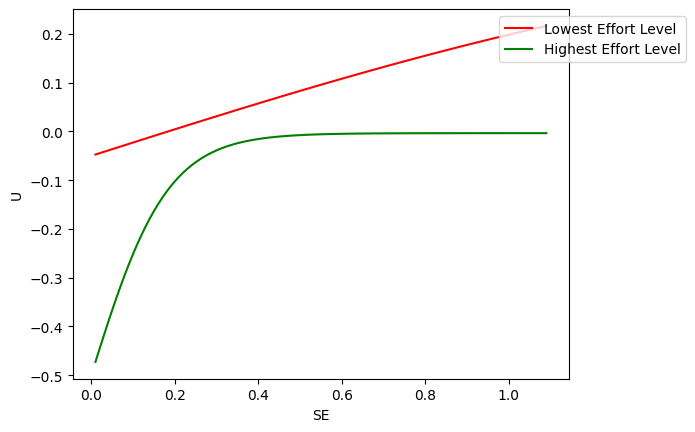

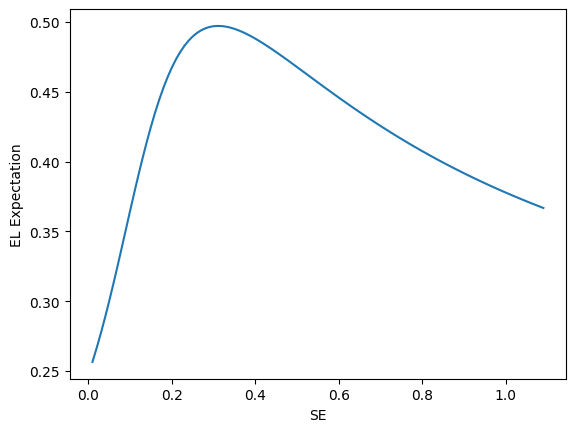

se_updates: -2310 out of 43800
Sim. attempts M: 24.41404109589041 SD: 69.68830190721137
Sim. performance M: 59.82176759084687 SD: 25.683589738488813
Table 1 Persons Regression of Performance on Self-Efficacy and Performance Ambiguity (Within Person)
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pe_se_hi [0. 0. 0. 0. 0. 0. 0. 0.]
True
F= nan p= nan
pe_se_lo [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pe_se_hi [0. 0. 0. 0. 0. 0. 0. 0.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


[1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pe_se_hi [0. 0. 0. 0. 0. 0. 0. 0.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [1. 1. 1. 1. 1. 1. 1. 1. 1.]
pe_se_hi [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True
F= nan p= nan
pe_se_lo [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pe_se_hi [0. 0. 0. 0. 0. 0. 0. 0.]
True
F= nan p= nan
pe_se_lo [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pe_se_hi [0. 0. 0. 0. 0. 0. 0. 0.]
True
F= nan p= nan

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1900: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '


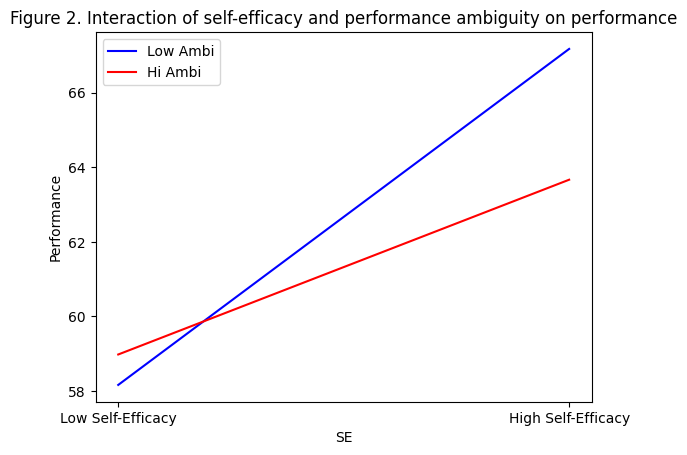

Clarion values:


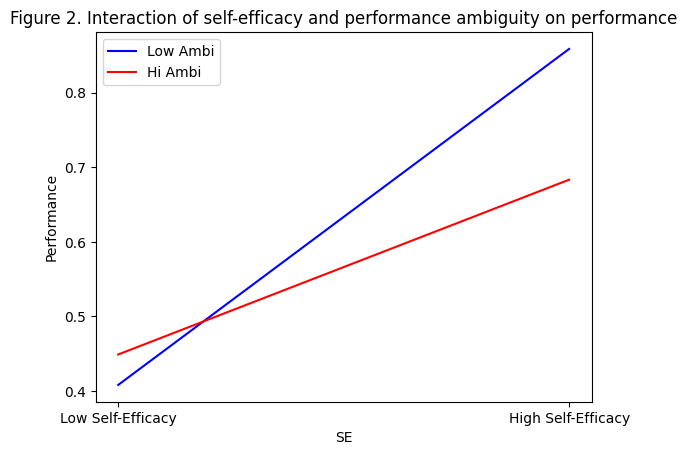

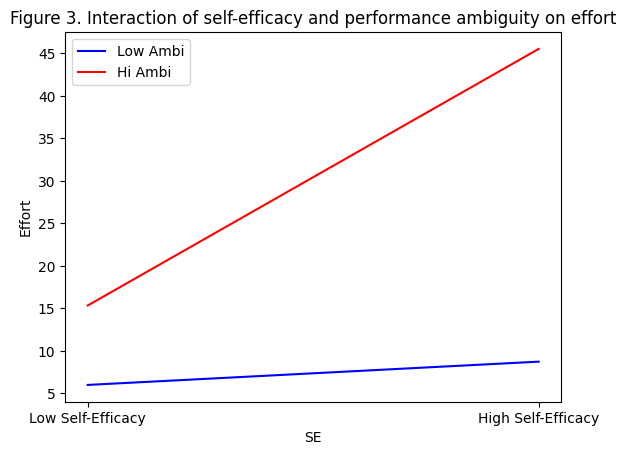

Clarion values:


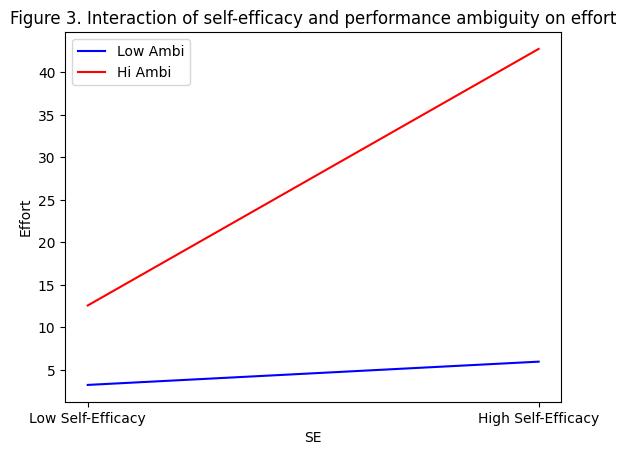

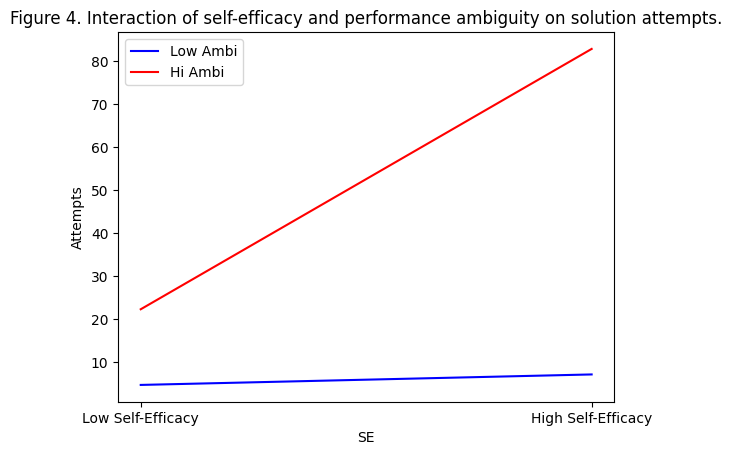

Clarion values:


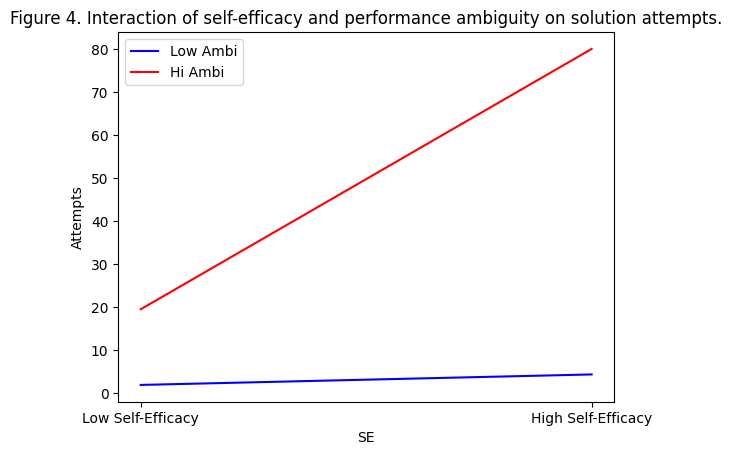

In [ ]:
N_p = 73*10

SE_mu = 66.62 #+ 2*17.09
SE_sd = 17.09 #* 0.0000001

SE = np.random.normal(loc=SE_mu, scale=SE_sd, size=(N_p, 3))
SE = np.sort(SE, axis=1)
SE_norm = SE / 100
SE_norm = np.clip(SE_norm, 0.0001, 1.0)

E_mu = 2.82 #Effort (attempts)
E_sd = 0.68
print('Experimental data; Attempts (mean, sd):',  E_mu, E_sd)

P_mu = 56.77 # Performance was operationalized as the percentage of possible solutions discovered during each block of five anagrams.
P_sd = 19.92
print('Experimental data; Performance (mean, sd):', P_mu, P_sd)

N_blocks = 4 # Participants completed four blocks of anagrams, with
N_ana_per_b = 5 # each block consisting of five anagrams.

EL_J_FLT = np.array([0.00001, 1, 2, 3, 4, 5, 6, 7, 8, 9]) / 10
tau = .1

se_learn_rate = 0.1 # 0.02
se_learn_noise = 0.0001 # 0.00002

sim_ambig = np.random.randint(2, size=(N_p))

VALUE_G = np.random.normal(loc=.5, scale=.15, size=(N_p))
VALUE_G = np.clip(VALUE_G, 0., 1.)

n_pos_sol = np.random.randint(low=1, high=5+1, size=(N_p, N_blocks, N_ana_per_b))  # number of posible solutions
# between-persons level of analysis (i.e., averaged across trials).

# Low ambiguity group: external feedback
# High ambiguity group: internal perception of progress
# each anagram had at least one possible solution, and as many as five possible solutions.



sim_n_pos_sol = []
sim_sol_p = np.zeros(N_p)
sim_attem_p = np.zeros(N_p)
sim_perf = np.zeros(N_p)
sim_effort = np.zeros((N_p, N_blocks))
sim_n_pos_sol_p = np.zeros(N_p)
sim_sol_p_b_a = np.zeros((N_p, N_blocks, N_ana_per_b))
sim_perf_p_b_a = np.zeros((N_p, N_blocks, N_ana_per_b))
sim_se_p_b_a = np.zeros((N_p, N_blocks, N_ana_per_b))
sim_effort_p_b_a = np.zeros((N_p, N_blocks, N_ana_per_b))
sim_attem_p_b_a = np.zeros((N_p, N_blocks, N_ana_per_b))
sim_ambig_p_b_a = np.zeros((N_p, N_blocks, N_ana_per_b))
se_updates = 0
se_updates_n = 0

a = 11/2
c = 0.5
figure_z(a=a, c=c, tau=tau, value_g=np.mean(VALUE_G))


for p_i in range(N_p):

  val_g = VALUE_G[p_i]


  N_t = 10
  time_a = 0
  b = 0
  el1 = None
  solved_int = 0


  for b_i in range(N_blocks):
    for a_i in range(N_ana_per_b):
      cu_perc1 = 0
      el_k = 0
      iter_i = 0

      se_p = np.mean(SE_norm[p_i])

      n_pos_sol_i = n_pos_sol[p_i, b_i, a_i]
      sim_n_pos_sol.append(n_pos_sol_i)
      sim_n_pos_sol_p[p_i] += n_pos_sol_i

      sim_ambig_p_b_a[p_i, b_i, a_i] = sim_ambig[p_i]

      # Initialization
      if sim_ambig[p_i] == 1:
        _, b, _, _, _, eos, el1, cu_perc1 = rea_util(t=0, T=0, el=el1, el_j=EL_J_FLT, cu_perc = cu_perc1, value_g=val_g, se=[se_p], a=a, c=c, b=b,
                                                      ext_fb=-1)
      else:
        _, b, _, _, b_prime, eos, el1, cu_perc1 = rea_util(t=0, T=0, el=el1, el_j=EL_J_FLT, cu_perc = cu_perc1, value_g=val_g, se=[se_p], a=a, c=c, b=b,
                                                            ext_fb=0, b_prime=1.25)


      el1 = np.zeros_like(el1) + 0.0001

      while True:
      # # Task
        iter_i += 1

        if sim_ambig[p_i] == 1:
          _, b, _, u_b, _, eos, el1 , cu_perc1 = rea_util(t=1, T=2, el=el1, el_j=EL_J_FLT, cu_perc = cu_perc1, value_g=val_g, se=[se_p], a=a, c=c,
                                                           b=b, ext_fb=solved_int, toa=3, use_perc=True)

          if el1[0][0] <= EL_J_FLT[0]:
            break
        else:
          _, b, _, u_b, b_prime, eos, el1 , cu_perc1 = rea_util(t=1, T=2, el=el1, el_j=EL_J_FLT, cu_perc = cu_perc1, value_g=val_g, se=[se_p], a=a, c=c,
                                                                 b=b, ext_fb=sim_sol_p_b_a[p_i, b_i, a_i]/n_pos_sol_i, b_prime=b_prime)


          if el1[0][0] <= EL_J_FLT[0] or sim_sol_p_b_a[p_i, b_i, a_i] == n_pos_sol_i:
            break


        el_k += el1[0][0]
        P_attempt = min(0.08 * el_k, 1.0)
        P_solved = min(se_p*0.00000003 + 0.59, 1)


        sim_effort[p_i, b_i] += el1[0][0]
        sim_effort_p_b_a[p_i, b_i, a_i] += el1[0][0]

        U_BOL_FLT = np.reshape(u_b, -1)

        attempt = np.random.choice([False, True], 1, p=[1-P_attempt, P_attempt])

        if attempt:

          sim_attem_p[p_i] += 1
          sim_attem_p_b_a[p_i, b_i, a_i] += 1
          solved = np.random.choice([False, True], 1, p=[1-P_solved, P_solved])
          if solved:
            if sim_sol_p_b_a[p_i, b_i, a_i] < n_pos_sol_i:
              sim_sol_p[p_i] += 1
              sim_sol_p_b_a[p_i, b_i, a_i] += 1
            else:
              solved = [False]

          solved_int = int(solved[0])

      sim_perf_p_b_a[p_i, b_i, a_i] = sim_sol_p_b_a[p_i, b_i, a_i]/n_pos_sol_i

      for se_i in range(SE_norm.shape[1]):
        se_updates_n += 1
        if sim_sol_p_b_a[p_i, b_i, a_i] >= se_i + 1:
          SE_norm[p_i, se_i] = (1 - se_learn_rate) * SE_norm[p_i, se_i]  + se_learn_rate * 1 + se_learn_noise
          if sim_ambig[p_i] == 1:
            se_updates += 1
        else:
          SE_norm[p_i, se_i] = (1 - se_learn_rate) * SE_norm[p_i, se_i]  + se_learn_rate * 0 + se_learn_noise
          if sim_ambig[p_i] == 1:
            se_updates -= 1

      sim_se_p_b_a[p_i, b_i, a_i] = np.mean(SE_norm[p_i])


  sim_perf[p_i] = sim_sol_p[p_i] / sim_n_pos_sol_p[p_i]

print('se_updates:', se_updates, 'out of', se_updates_n)
sim_effort_a = np.mean(sim_effort, axis=1)

sim_attem_p_a = sim_attem_p / (N_blocks * N_ana_per_b)

print('Sim. attempts M:', np.mean(sim_attem_p_a), 'SD:', np.std(sim_attem_p_a))
sim_perf_100 = sim_perf * 100
print('Sim. performance M:', np.mean(sim_perf_100), 'SD:', np.std(sim_perf_100))

# x = sim_ambig
# y = sim_perf
# print('Pearsons r value (correlation) (Ambiguity, Performance): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])

# x = np.reshape(sim_se_p_b_a, -1)
# y = np.reshape(sim_perf_p_b_a, -1)
# print('Pearsons r value (correlation) (SE, Performance): r=:', pearsonr(x, y)[0], 'p=', pearsonr(x, y)[1])



print('Table 1 Persons Regression of Performance on Self-Efficacy and Performance Ambiguity (Within Person)')

ap_gamma = []
ap_SE = []
ap_p = []
ap_r2 = []

sep_gamma = []
sep_SE = []
sep_p = []
sep_r2 = []

sep_gamma_am0 = []
sep_SE_am0 = []
sep_p_am0 = []
sep_r2_am0 = []

sep_gamma_am1 = []
sep_SE_am1 = []
sep_p_am1 = []
sep_r2_am1 = []

ep_gamma = []
ep_SE = []
ep_p = []
ep_r2 = []

sa_gamma = []
sa_SE = []
sa_p = []
sa_r2 = []

se_gamma = []
se_SE = []
se_p = []
se_r2 = []

ea_gamma = []
ea_SE = []
ea_p = []
ea_r2 = []

seamp_gamma = []
seamp_p = []

for per_i in range(N_p):
  se_1 = sim_se_p_b_a[per_i]
  se_1 = np.reshape(se_1, (-1))

  pe_1 = sim_perf_p_b_a[per_i]
  pe_1 = np.reshape(pe_1, (-1))

  sim_ambig1 = sim_ambig_p_b_a[per_i]
  sim_ambig1 = np.reshape(sim_ambig1, (-1))

  idx_hi_se = np.where(se_1[:] >= np.mean(se_1))[0]
  idx_lo_se = np.where(se_1[:] < np.mean(se_1))[0]

  pe_se_lo = pe_1[idx_lo_se]
  pe_se_hi = pe_1[idx_hi_se]

  anova_res = f_oneway(pe_se_lo, pe_se_hi)

  # print('1 Dependent variable: Performance')
  # print('Low vs High SE')
  # print('F=', anova_res[0], 'p=', anova_res[1])

  if math.isnan(anova_res[0]) or math.isnan(anova_res[1]):
    # print('F=', anova_res[0], 'p=', anova_res[1])
    # print('pe_se_lo', pe_se_lo)
    # print('pe_se_hi', pe_se_hi)
    if np.std(pe_se_lo)==0 and np.std(pe_se_hi)==0 and np.mean(pe_se_lo) == np.mean(pe_se_hi):
      print(np.std(pe_se_lo)==0 and np.std(pe_se_hi)==0 and np.mean(pe_se_lo) == np.mean(pe_se_hi))
      sep_gamma.append(0)
      sep_p.append(1)
  else:
    sep_gamma.append(anova_res[0])
    sep_p.append(anova_res[1])


print('Main Effects and Interaction Effects on Performance and Effort at the Within-Persons Level of Analysis')
print('1 Dependent variable: Performance')
print('Self-efficacy F=', np.mean(sep_gamma), 'p=',np.mean(sep_p))


# data
df = pd.DataFrame({'s_e': se_1, 'per': pe_1, 'ambg': sim_ambig1})

# two-way ANOVA
model = ols('per ~ s_e + ambg + s_e:ambg', data=df).fit()
print('2-way ANOVA:\n', sm.stats.anova_lm(model, typ=2))

sep_gamma = []
sep_p = []

print('Main Effects and Interaction Effects on Performance and Effort at the Between-Persons Level of Analysis')
print('1 Dependent variable: Performance')
se_1 = sim_se_p_b_a
se_1 = np.reshape(se_1, (N_p, -1))
se_1 = np.mean(se_1, axis=1)
se_1 = np.reshape(se_1, (N_p))

pe_1 = sim_perf_p_b_a
pe_1 = np.reshape(pe_1, (N_p, -1))
pe_1 = np.mean(pe_1, axis=1)
pe_1 = np.reshape(pe_1, (N_p))

sim_ambig1 = sim_ambig_p_b_a
sim_ambig1 = np.reshape(sim_ambig1, (N_p, -1))
sim_ambig1 = np.mean(sim_ambig1, axis=1)
sim_ambig1 = np.reshape(sim_ambig1, (N_p))

idx_hi_se = np.where(se_1[:] > np.mean(se_1))[0]
idx_lo_se = np.where(se_1[:] < np.mean(se_1))[0]

pe_se_lo = pe_1[idx_lo_se]
pe_se_hi = pe_1[idx_hi_se]

anova_res = f_oneway(pe_se_lo, pe_se_hi)
# print('F=', anova_res[0], 'p=', anova_res[1])

if math.isnan(anova_res[0]) or math.isnan(anova_res[1]):
  print('F=', anova_res[0], 'p=', anova_res[1])
else:
  sep_gamma.append(anova_res[0])
  sep_p.append(anova_res[1])

print('Self-efficacy F=',np.mean(sep_gamma), 'p=',np.mean(sep_p))

sep_gamma = []
sep_p = []

idx_hi_am = np.where(sim_ambig1==1)[0]
idx_lo_am = np.where(sim_ambig1==0)[0]

pe_am_lo = pe_1[idx_lo_am]
pe_am_hi = pe_1[idx_hi_am]

anova_res = f_oneway(pe_am_lo, pe_am_hi)
# print('F=', anova_res[0], 'p=', anova_res[1])

if math.isnan(anova_res[0]) or math.isnan(anova_res[1]):
  print('F=', anova_res[0], 'p=', anova_res[1])
else:
  sep_gamma.append(anova_res[0])
  sep_p.append(anova_res[1])

print('Ambiguity F=', np.mean(sep_gamma), 'p=',np.mean(sep_p))

#create data
df = pd.DataFrame({'s_e': se_1, 'per': pe_1, 'ambg': sim_ambig1})

#perform two-way ANOVA
model = ols('per ~ s_e + ambg + s_e:ambg', data=df).fit()
print('2-way ANOVA:\n', sm.stats.anova_lm(model, typ=2))


sep_gamma = []
sep_p = []

idx_hi_se_hi_am = np.where((se_1[:] > np.mean(se_1)) & (sim_ambig1[:] == 1))[0]
idx_lo_se_lo_am = np.where((se_1[:] < np.mean(se_1)) & (sim_ambig1[:] == 0))[0]
idx_hi_se_lo_am = np.where((se_1[:] > np.mean(se_1)) & (sim_ambig1[:] == 0))[0]
idx_lo_se_hi_am = np.where((se_1[:] < np.mean(se_1)) & (sim_ambig1[:] == 1))[0]

pe_se_hi_am_hi = pe_1[idx_hi_se_hi_am]
pe_se_lo_am_lo = pe_1[idx_lo_se_lo_am]
pe_se_hi_am_lo = pe_1[idx_hi_se_lo_am]
pe_se_lo_am_hi = pe_1[idx_lo_se_hi_am]


anova_res = f_oneway(pe_se_hi_am_hi, pe_se_lo_am_lo, pe_se_hi_am_lo, pe_se_lo_am_hi)

if math.isnan(anova_res[0]) or math.isnan(anova_res[1]):
  print('F=', anova_res[0], 'p=', anova_res[1])
  sep_gamma.append(0.0)
  sep_p.append(1.0)
else:
  sep_gamma.append(anova_res[0])
  sep_p.append(anova_res[1])

print('Self-efficacy x Ambiguity F=', np.mean(sep_gamma), 'p=',np.mean(sep_p))


print('Table 1. Means, Standard Deviations, and Intercorrelations at the Between-Persons Level of Analysis')

sim_ambig1 = np.reshape(sim_ambig_p_b_a, (N_p, -1))
sim_ambig1 = np.mean(sim_ambig1, axis=1)
print('1. Performance ambiguity', np.mean(sim_ambig), np.std(sim_ambig))

# print('2. Ability')

se_1 = np.reshape(sim_se_p_b_a, (N_p, -1))
se_1 = np.mean(se_1, axis=1)

print('3. Self-efficacy', np.mean(se_1), np.std(se_1), '1: r=', pearsonr(se_1, sim_ambig1)[0], 'p=', pearsonr(se_1, sim_ambig1)[1])

ef_1 = np.reshape(sim_attem_p_b_a, (N_p, -1))
ef_1 = np.mean(ef_1, axis=1)

print('4. Effort (attempts)', np.mean(ef_1), np.std(ef_1), '1: r=', pearsonr(ef_1, sim_ambig1)[0], 'p=', pearsonr(ef_1, sim_ambig1)[1], '3: r=', pearsonr(ef_1, se_1)[0], 'p=', pearsonr(ef_1, se_1)[1])

ef_2_1 = np.reshape(sim_effort_p_b_a, (N_p, -1))
ef_2_1 = np.mean(ef_2_1, axis=1)

print('5. Effort (self-report)', np.mean(ef_2_1), np.std(ef_2_1), '1: r=', pearsonr(ef_2_1, sim_ambig1)[0], 'p=', pearsonr(ef_2_1, sim_ambig1)[1], '3: r=', pearsonr(ef_2_1, se_1)[0], 'p=', pearsonr(ef_2_1, se_1)[1], '4: r=', pearsonr(ef_2_1, ef_1)[0], 'p=', pearsonr(ef_2_1, ef_1)[1])

pe_1 = np.reshape(sim_perf_p_b_a, (N_p, -1))
pe_1 = np.mean(pe_1, axis=1)
print('6. Performance', np.mean(pe_1), np.std(pe_1), '1: r=', pearsonr(pe_1, sim_ambig1)[0], 'p=', pearsonr(pe_1, sim_ambig1)[1], '3: r=', pearsonr(pe_1, se_1)[0], 'p=', pearsonr(pe_1, se_1)[1], '4: r=', pearsonr(pe_1, ef_1)[0], 'p=', pearsonr(pe_1, ef_1)[1], '5: r=', pearsonr(pe_1, ef_2_1)[0], 'p=', pearsonr(pe_1, ef_2_1)[1])

sim_perf_lo_ambi_lo_se = []
sim_perf_hi_ambi_hi_se = []
sim_perf_hi_ambi_lo_se = []
sim_perf_lo_ambi_hi_se = []

sim_perf_p_b_a2 = np.reshape(sim_perf_p_b_a, (N_p, -1))



# Within person
# for i in range(N_p):
#   threshold = np.mean(np.reshape(sim_se_p_b_a[i, :,:], (-1)))

#   for j in range(N_blocks):
#     for k in range(N_ana_per_b):

#       if sim_ambig[i] == 1:
#         if sim_perf_p_b_a[i,j,k] < 0.5:
#           sim_perf_hi_ambi_lo_se.append(sim_perf_p_b_a[i,j,k])
#         else:
#           if sim_perf_p_b_a[i,j,k] > 0.5:
#             sim_perf_hi_ambi_hi_se.append(sim_perf_p_b_a[i,j,k])
#       else:
#         if sim_perf_p_b_a[i,j,k] < 0.5:
#           sim_perf_lo_ambi_lo_se.append(sim_perf_p_b_a[i,j,k])
#         else:
#           if sim_perf_p_b_a[i,j,k] > 0.5:
#             sim_perf_lo_ambi_hi_se.append(sim_perf_p_b_a[i,j,k])
# End of Within person

# Between person
# sim_perf_lo_ambi_lo_se = []
# sim_perf_hi_ambi_hi_se = []
# sim_perf_hi_ambi_lo_se = []
# sim_perf_lo_ambi_hi_se = []

# sim_se_p_b_a22 = np.reshape(sim_perf_p_b_a, (N_p, -1))
# sim_se_p_b_a22 = np.mean(sim_se_p_b_a22, axis=1)
# threshold = np.mean(sim_se_p_b_a22)

# for i in range(N_p):
#   if sim_ambig[i] == 1:
#     if sim_se_p_b_a22[i] < threshold:
#       sim_perf_hi_ambi_lo_se.append(sim_se_p_b_a22[i])
#     else:
#       if sim_se_p_b_a22[i] > threshold:
#         sim_perf_hi_ambi_hi_se.append(sim_se_p_b_a22[i])
#   else:
#     if sim_se_p_b_a22[i] < threshold:
#       sim_perf_lo_ambi_lo_se.append(sim_se_p_b_a22[i])
#     else:
#       if sim_se_p_b_a22[i] > threshold:
#         sim_perf_lo_ambi_hi_se.append(sim_se_p_b_a22[i])
# End of Between person


threshold = np.mean(se_1)
lo_se = (np.array(se_1) < threshold)
hi_se = (np.array(se_1) > threshold)

sim_lo_se = np.extract(lo_se, se_1)
sim_hi_se = np.extract(hi_se, se_1)

lo_ambi_lo_se = (np.array(sim_ambig1)==0) & (np.array(se_1) < threshold)
lo_ambi_hi_se = (np.array(sim_ambig1)==0) & (np.array(se_1) > threshold)
hi_ambi_lo_se = (np.array(sim_ambig1)==1) & (np.array(se_1) < threshold)
hi_ambi_hi_se = (np.array(sim_ambig1)==1) & (np.array(se_1) > threshold)

sim_perf_lo_ambi_lo_se = np.extract(lo_ambi_lo_se, pe_1)
sim_perf_lo_ambi_hi_se = np.extract(lo_ambi_hi_se, pe_1)
sim_perf_hi_ambi_lo_se = np.extract(hi_ambi_lo_se, pe_1)
sim_perf_hi_ambi_hi_se = np.extract(hi_ambi_hi_se, pe_1)

sim_perf_lo_ambi_lo_se = np.reshape(sim_perf_lo_ambi_lo_se, (-1))
sim_perf_lo_ambi_lo_se = np.mean(sim_perf_lo_ambi_lo_se)

sim_perf_hi_ambi_hi_se = np.reshape(sim_perf_hi_ambi_hi_se, (-1))
sim_perf_hi_ambi_hi_se = np.mean(sim_perf_hi_ambi_hi_se)

sim_perf_hi_ambi_lo_se = np.reshape(sim_perf_hi_ambi_lo_se, (-1))
sim_perf_hi_ambi_lo_se = np.mean(sim_perf_hi_ambi_lo_se)

sim_perf_lo_ambi_hi_se = np.reshape(sim_perf_lo_ambi_hi_se, (-1))
sim_perf_lo_ambi_hi_se = np.mean(sim_perf_lo_ambi_hi_se)

plt.plot([1, 2], [50+sim_perf_lo_ambi_lo_se*20, 50+sim_perf_lo_ambi_hi_se*20], 'b', label='Low Ambi')
plt.plot([1, 2], [50+sim_perf_hi_ambi_lo_se*20, 50+sim_perf_hi_ambi_hi_se*20], 'r', label='Hi Ambi')
plt.title("Figure 2. Interaction of self-efficacy and performance ambiguity on performance")
plt.ylabel('Performance')
plt.xlabel('SE')
labels = ['Low Self-Efficacy', 'High Self-Efficacy']
plt.xticks([1, 2], labels)
plt.legend(ncol=1, fontsize=10)
plt.show()

print('Clarion values:')

plt.plot([1, 2], [sim_perf_lo_ambi_lo_se, sim_perf_lo_ambi_hi_se], 'b', label='Low Ambi')
plt.plot([1, 2], [sim_perf_hi_ambi_lo_se, sim_perf_hi_ambi_hi_se], 'r', label='Hi Ambi')
plt.title("Figure 2. Interaction of self-efficacy and performance ambiguity on performance")
plt.ylabel('Performance')
plt.xlabel('SE')
labels = ['Low Self-Efficacy', 'High Self-Efficacy']
plt.xticks([1, 2], labels)
plt.legend(ncol=1, fontsize=10)
plt.show()



sim_perf_lo_ambi_lo_se = np.extract(lo_ambi_lo_se, ef_2_1)
sim_perf_lo_ambi_hi_se = np.extract(lo_ambi_hi_se, ef_2_1)
sim_perf_hi_ambi_lo_se = np.extract(hi_ambi_lo_se, ef_2_1)
sim_perf_hi_ambi_hi_se = np.extract(hi_ambi_hi_se, ef_2_1)

sim_perf_lo_ambi_lo_se = np.mean(sim_perf_lo_ambi_lo_se)
sim_perf_hi_ambi_hi_se = np.mean(sim_perf_hi_ambi_hi_se)
sim_perf_hi_ambi_lo_se = np.mean(sim_perf_hi_ambi_lo_se)
sim_perf_lo_ambi_hi_se = np.mean(sim_perf_lo_ambi_hi_se)


plt.plot([1, 2], [sim_perf_lo_ambi_lo_se+2.75, sim_perf_lo_ambi_hi_se+2.75], 'b', label='Low Ambi')
plt.plot([1, 2], [sim_perf_hi_ambi_lo_se+2.75, sim_perf_hi_ambi_hi_se+2.75], 'r', label='Hi Ambi')

plt.title("Figure 3. Interaction of self-efficacy and performance ambiguity on effort")
plt.ylabel('Effort')
plt.xlabel('SE')
labels = ['Low Self-Efficacy', 'High Self-Efficacy']
plt.xticks([1, 2], labels)
plt.legend(ncol=1, fontsize=10)
plt.show()

print('Clarion values:')

plt.plot([1, 2], [sim_perf_lo_ambi_lo_se, sim_perf_lo_ambi_hi_se], 'b', label='Low Ambi')
plt.plot([1, 2], [sim_perf_hi_ambi_lo_se, sim_perf_hi_ambi_hi_se], 'r', label='Hi Ambi')

plt.title("Figure 3. Interaction of self-efficacy and performance ambiguity on effort")
plt.ylabel('Effort')
plt.xlabel('SE')
labels = ['Low Self-Efficacy', 'High Self-Efficacy']
plt.xticks([1, 2], labels)
plt.legend(ncol=1, fontsize=10)
plt.show()


sim_perf_lo_ambi_lo_se = np.extract(lo_ambi_lo_se, ef_1)
sim_perf_lo_ambi_hi_se = np.extract(lo_ambi_hi_se, ef_1)
sim_perf_hi_ambi_lo_se = np.extract(hi_ambi_lo_se, ef_1)
sim_perf_hi_ambi_hi_se = np.extract(hi_ambi_hi_se, ef_1)

sim_perf_lo_ambi_lo_se = np.mean(sim_perf_lo_ambi_lo_se)
sim_perf_hi_ambi_hi_se = np.mean(sim_perf_hi_ambi_hi_se)
sim_perf_hi_ambi_lo_se = np.mean(sim_perf_hi_ambi_lo_se)
sim_perf_lo_ambi_hi_se = np.mean(sim_perf_lo_ambi_hi_se)

plt.plot([1, 2], [sim_perf_lo_ambi_lo_se+2.75, sim_perf_lo_ambi_hi_se+2.75], 'b', label='Low Ambi')
plt.plot([1, 2], [sim_perf_hi_ambi_lo_se+2.75, sim_perf_hi_ambi_hi_se+2.75], 'r', label='Hi Ambi')
# ll = plt.scatter(1, sim_perf_lo_ambi_lo_se, c='b', alpha=0.5)
# hh = plt.scatter(2, sim_perf_hi_ambi_hi_se, c='r', alpha=0.5)
# hl = plt.scatter(1, sim_perf_hi_ambi_lo_se, c='k', alpha=0.5)
# lh = plt.scatter(2, sim_perf_lo_ambi_hi_se, c='y', alpha=0.5)
plt.title("Figure 4. Interaction of self-efficacy and performance ambiguity on solution attempts.")
plt.ylabel('Attempts')
plt.xlabel('SE')
labels = ['Low Self-Efficacy', 'High Self-Efficacy']
plt.xticks([1, 2], labels)
plt.legend(ncol=1, fontsize=10)
plt.show()

print('Clarion values:')

plt.plot([1, 2], [sim_perf_lo_ambi_lo_se, sim_perf_lo_ambi_hi_se], 'b', label='Low Ambi')
plt.plot([1, 2], [sim_perf_hi_ambi_lo_se, sim_perf_hi_ambi_hi_se], 'r', label='Hi Ambi')
# ll = plt.scatter(1, sim_perf_lo_ambi_lo_se, c='b', alpha=0.5)
# hh = plt.scatter(2, sim_perf_hi_ambi_hi_se, c='r', alpha=0.5)
# hl = plt.scatter(1, sim_perf_hi_ambi_lo_se, c='k', alpha=0.5)
# lh = plt.scatter(2, sim_perf_lo_ambi_hi_se, c='y', alpha=0.5)
plt.title("Figure 4. Interaction of self-efficacy and performance ambiguity on solution attempts.")
plt.ylabel('Attempts')
plt.xlabel('SE')
labels = ['Low Self-Efficacy', 'High Self-Efficacy']
plt.xticks([1, 2], labels)
plt.legend(ncol=1, fontsize=10)
plt.show()

In [ ]:
y = [1.,         1.,         1.,         0.2,        1. ,        1.,
 1.   ,      1.,         0.6  ,      0.33333333 ,0.25    ,   0.,
 1.   ,      1.  ,       1.   ,      1.  ,       1.  ,       0.5,
 1.  ,       0.75      ]
# y = [1. ,1. ,1. ,1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]

X = [0.6394564,  0.67561076, 0.70814969, 0.67076805, 0.63712458, 0.64017879,
 0.67626091, 0.67540149, 0.70796134, 0.67059854, 0.63697202, 0.57337481,
 0.61613733, 0.58795693, 0.56259457 ,0.60643512 ,0.6458916 , 0.61473578,
 0.6533622 , 0.68812598]

x = sm.add_constant(X)
results = sm.OLS(y, x).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -18.00
Date:                Tue, 25 Jul 2023   Prob (F-statistic):               1.00
Time:                        17:12:55   Log-Likelihood:                 671.70
No. Observations:                  20   AIC:                            -1339.
Df Residuals:                      18   BIC:                            -1337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   2.37e-15   4.23e+14      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


M. Seo, R. Ilies, (2009) / Organizational Behavior and Human Decision Processes 109 120–133

In this paper, we examined the within-person relationship between self-efficacy and performance in an
Internet-based stock investment simulation in which participants engaged in a series of stock trading
activities trying to achieve performance goals in response to dynamic task environments (performance
feedback and stock market movements).*italicized text*

In [ ]:
def gain_factor(gain_alloc, time_alloc_c):
  # gain = -.1,.., .., .., +.1
  # If  gain > 0,
  # then factor(gain) = (np.abs(gain)+1) / time_alloc_c^2
  # Else  factor(gain) = (np.abs(gain)+1) * time_alloc_c^2
  out = []
  for g in gain_alloc:
    if  g > 0:
      out.append( (np.abs(g)+1) / (time_alloc_c*time_alloc_c) )
    else:
      out.append ( (np.abs(g)+1) * (time_alloc_c*time_alloc_c) )

  return out

N_c = 1870 # As a result, we used 1870 cases of data completed by ...
N_p = 101*10  # ... 101 participants for data analysis.
N_d = 20  # stock investment simulation for 20 consecutive business days

# Performance: 12 performance goal levels: high="more than 30% above the market return” and low="no less than 5% below the market return."

# Effort: (1)‘intended time,’ = eight response choices in a descending order (‘‘more than 1 h” to ‘‘less than 10 min”); (2) ‘actual time,’

# Goal level: the same utility function as has been used to choose one of the effort levels in Sun et al. (2002) is used here to
# choose one of these specific goals (in utility calculation, notably, with regard to the value of the
# general goal already chosen and with a specific goal playing the same role as an effort level here).

# Higher specific goals lead to higher value(g)

N_GOAL_L = 12
N_PERF_L = N_GOAL_L
EL_J_FLT = np.linspace(0.01, 1., num=N_PERF_L)
GAIN = np.linspace(-.1, .1, num=N_PERF_L)  #np.arange(-.1, .11, 0.01)
GAIN_I = np.arange(N_PERF_L)
assert(N_PERF_L > 10)

goals = np.array([-.05, -.03, -.01, 0, .01, .03, .05, .1, .15, .2, .25, .3])
goallevel_inds = np.arange(N_GOAL_L)

SE_mu, SE_sd = 2.46, 0.48 #  Self-efficacy 2.46 0.48
SE = np.random.normal(loc=SE_mu, scale=SE_sd, size=(N_p, N_PERF_L))
SE = np.sort(SE, axis=1)
SE_norm = (SE - 0) / 4.5
SE_norm = np.clip(SE_norm, 0, 1)

G_mu, G_sd = 3.40, 2.33  # Goal level 3.40 2.33
E_mu, E_sd = 2.49, 1.96  # Actual effort 2.49 1.96
P_mu, P_sd  = 0.49, 3.36 # Performance 0.49 3.36


VALUE_GG = np.random.normal(loc=.5, scale=.15, size=(N_p))
VALUE_GG = np.clip(VALUE_GG, 0.00001, 1.)


tau = .01
# goal l
a2 = 1.5 # recent 0.7 # standard 5/2
c2 = 0.5 # recent 0.1 #standard 0.5
# effort l
a = 0.97 # 0.7 #5/2
c = .17 # 0.1 # 0.5

INDIV_DI = np.random.normal(loc=.0, scale=.005, size=(N_p))  # value of the general goal
INDIV_DI = np.clip(INDIV_DI, -0.1, 0.1)

se_learn_rate = 0.1
se_learn_noise_rate = 0.001
se_learn_noise_options = [-1*se_learn_noise_rate, 0, se_learn_noise_rate]
se_learn_noise = np.random.choice(se_learn_noise_options, size=[N_p], p=[1/3, 1/3, 1/3])

gain_prob_alloc = []
U_BOL_FLT = []
se_p = 0

# between-persons level of analysis

# Low ambiguity group: external feedback
# High ambiguity group: internal perception of progress
# each anagram had at least one possible solution, and as many as five possible solutions.

# Metacognitive params
mc_noise = 0.002
mc_noise_options = [-1*mc_noise, 0, mc_noise]
mc_noise_p = np.random.choice(mc_noise_options, size=[N_p], p=[1/3, 1/3, 1/3])
mc_m = 12.0 #24.0
sr_tr = .6  # 0.7 threshold

sim_p = np.zeros((N_p, N_d))
sim_pp = np.zeros((N_p, N_d))
sim_se = np.zeros((N_p, N_d))
sim_gl = np.zeros((N_p, N_d))
sim_act_ef = np.zeros((N_p, N_d))

for p_i in range(N_p):

  sim_sol_p = 0
  b = 0
  gain_t = 0
  val_gg = VALUE_GG[p_i]

  for d_i in range(N_d):

    se_p = np.mean(SE_norm[p_i, :], axis=0)
    sim_pp[p_i, d_i] = gain_t
    sim_se[p_i, d_i] = se_p


    # Choosing goal level
    _, u_goall_bol = eel_np(value_g=val_gg, el_j = goals, se=[se_p], a=a2, c=c2)
    U_BOL_GOALL_FLT = np.reshape(u_goall_bol, -1)
    val_g_i = np.random.choice(goallevel_inds, 1, p=U_BOL_GOALL_FLT)
    sim_gl[p_i, d_i] = goals[val_g_i]

    GOALL_FLT = np.reshape(goals, -1)
    val_g = val_gg  # GOALL_FLT[-val_g_i-1]
    goal_gain_p = goals[val_g_i] #goals[-val_g_i-1]

    el_c = 0  # cumulative effort
    time_alloc_c = 0  # cumulative time allocated

    while True:

      # Choosing effort level
      _, u_b = eel_np(value_g=val_g, el_j = EL_J_FLT, se=[se_p], a=a, c=c)
      U_BOL_FLT = np.reshape(u_b, -1)
      el_s = np.random.choice(EL_J_FLT, 1, p=U_BOL_FLT)
      el_c += el_s
      time_alloc_c = el_c

      # Metacognitive Monitoring
      sr = tanh4( (el_c/(1 + sim_gl[p_i, d_i]) * mc_m + mc_noise_p[p_i]) )

      if sr > sr_tr:
        break
      else:
        val_g = val_g * (1 + 0.2 * se_p - 0.1)
        se_p = max(0, se_p - 0.1)

    sim_act_ef[p_i, d_i] = time_alloc_c

    bias_time_alloc_c = (time_alloc_c[0]/(0.87+3*0.25))*0.2 - 0.1 + INDIV_DI[p_i]
    gain_alloc = gaussian(x=GAIN, mu=bias_time_alloc_c)
    gain_prob_alloc = np.reshape(bol(gain_alloc, t = tau), (-1))

    try:
      gain_i_t = np.random.choice(GAIN_I, 1, p=gain_prob_alloc)[0]
      gain_t = GAIN[gain_i_t]
    except:
      print('gain_prob_alloc', gain_prob_alloc, gain_alloc, INDIV_DI[p_i], time_alloc_c, (np.abs(GAIN)+1))


    sim_p[p_i, d_i] = gain_t
    sim_sol_p += gain_t


    for i in range(N_PERF_L):
      if GAIN[i] <= gain_t:
        SE_norm[p_i, i] = (1 - se_learn_rate) * SE_norm[p_i, i]  + se_learn_rate * 1 + se_learn_noise[p_i]

      else:
        SE_norm[p_i, i] = (1 - se_learn_rate) * SE_norm[p_i, i]  + se_learn_rate * 0 + se_learn_noise[p_i]






In [ ]:
# Between person effect
mean_sim_p = np.ones((N_p))
mean_sim_pp = np.ones((N_p))

for i in range(N_p):
  for j in range(N_d):

    a = 1 + sim_p[i, j]
    mean_sim_p[i] *= a

    b = 1 + sim_pp[i, j]
    mean_sim_pp[i] *= b

mean_sim_p = mean_sim_p * 100 - 100
mean_sim_pp = mean_sim_pp * 100 - 100

sim_p_bw = mean_sim_p

sim_pp_bw = mean_sim_pp

sim_se_bw = np.mean(sim_se, axis=1)

sim_gl_bw = np.mean(sim_gl, axis=1)

sim_act_ef_bw = np.mean(sim_act_ef, axis=1)

sim_p_bw = np.reshape(sim_p_bw, (-1))
sim_pp_bw = np.reshape(sim_pp_bw, (-1))
sim_se_bw = np.reshape(sim_se_bw, (-1))
sim_gl_bw = np.reshape(sim_gl_bw, (-1))
sim_act_ef_bw = np.reshape(sim_act_ef_bw, (-1))


print('Between-person analysis')
print('Table 1. Means, standard deviations, variance proportions, and correlations (simulation).')
print('1 Past performance', np.mean(sim_pp_bw), np.std(sim_pp_bw))
print('2 Self-efficacy', np.mean(sim_se_bw), np.std(sim_se_bw), '1: r=', pearsonr(sim_se_bw, sim_pp_bw)[0], 'p=', pearsonr(sim_se_bw, sim_pp_bw)[1])
print('3 Goal level', np.mean(sim_gl_bw), np.std(sim_gl_bw), '1: r=', pearsonr(sim_gl_bw, sim_pp_bw)[0], 'p=', pearsonr(sim_gl_bw, sim_pp_bw)[1], '2: r=', pearsonr(sim_gl_bw, sim_se_bw)[0], 'p=', pearsonr(sim_gl_bw, sim_se_bw)[1])
print('5 Actual effort', np.mean(sim_act_ef_bw), np.std(sim_act_ef_bw), '1: r=', pearsonr(sim_act_ef_bw, sim_pp_bw)[0], 'p=', pearsonr(sim_act_ef_bw, sim_pp_bw)[1], '2: r=', pearsonr(sim_act_ef_bw, sim_se_bw)[0], 'p=', pearsonr(sim_act_ef_bw, sim_se_bw)[1], '3: r=', pearsonr(sim_act_ef_bw, sim_gl_bw)[0], 'p=', pearsonr(sim_act_ef_bw, sim_gl_bw)[1] )
print('6 Performance', np.mean(sim_p_bw), np.std(sim_p_bw), '1: r=', pearsonr(sim_p_bw, sim_pp_bw)[0], 'p=', pearsonr(sim_p_bw, sim_pp_bw)[1], '2: r=', pearsonr(sim_p_bw, sim_se_bw)[0], 'p=', pearsonr(sim_p_bw, sim_se_bw)[1], '3: r=', pearsonr(sim_p_bw, sim_gl_bw)[0], 'p=', pearsonr(sim_p_bw, sim_gl_bw)[1], '5: r=', pearsonr(sim_p_bw, sim_act_ef_bw)[0], 'p=', pearsonr(sim_p_bw, sim_act_ef_bw)[1] )


sim_pp_bw.shape, sim_se_bw.shape (1010,) (1010,)
Between-person analysis
Table 1. Means, standard deviations, variance proportions, and correlations (simulation).
1 Past performance -1.5771275848082247 47.595954598843704
2 Self-efficacy 0.5232400001097322 0.08575294114319337 1: r= 0.947648660198599 p= 0.0
3 Goal level 0.013231683168316825 0.07776301130273901 1: r= 0.5824884550705447 p= 8.289669981515504e-93 2: r= 0.5030653173241528 p= 6.74384473690743e-66
5 Actual effort 0.7277009900990099 0.28195252514326463 1: r= 0.918639895515547 p= 0.0 2: r= 0.9565475351561139 p= 0.0 3: r= 0.4887048365951582 p= 9.457116334073198e-62
6 Performance -1.2292274824599996 49.709947818681975 1: r= 0.997956467561309 p= 0.0 2: r= 0.942916307795797 p= 0.0 3: r= 0.58645060681595 p= 2.3759730352674906e-94 5: r= 0.9153915235385756 p= 0.0
Within-person analysis
Table 1. Means, standard deviations, variance proportions, and correlations (simulation).
1 Past performance -1.949128676045874 0.8805376314584477
2 Self

In [ ]:
# Within-person analysis

sim_p_wn = np.ones((N_p, N_d))
sim_pp_wn = np.ones((N_p, N_d))

for i in range(N_p):
  for j in range(N_d):

    a = 1 + sim_p[i, j]
    b = 1 + sim_pp[i, j]

    if j > 0:
      sim_p_wn[i, j] = a * sim_p_wn[i, j-1]
      sim_pp_wn[i, j] = b * sim_pp_wn[i, j-1]
    else:
      sim_p_wn[i, j] = a
      sim_pp_wn[i, j] = b

sim_p_wn = sim_p_wn * 100 - 100
sim_pp_wn = sim_pp_wn * 100 - 100

# # averaged within-individual correlations
# avg_r = 0
# avg_p = 0

# for i in range(N_p):
#   avg_r += pearsonr(sim_act_ef[i], sim_se[i])[0]
#   avg_p += pearsonr(sim_act_ef[i], sim_se[i])[1]

# avg_r = avg_r / N_p
# avg_p = avg_p / N_p
# print(avg_r, avg_p)

sim_p_wn = np.mean(sim_p_wn, axis=0)
sim_pp_wn = np.mean(sim_pp_wn, axis=0)

sim_se_wn = np.mean(sim_se, axis=0)

sim_gl_wn = np.mean(sim_gl, axis=0)

sim_act_ef_wn = np.mean(sim_act_ef, axis=0)

sim_p_wn = np.reshape(sim_p_wn, (-1))
sim_pp_wn = np.reshape(sim_pp_wn, (-1))
sim_se_wn = np.reshape(sim_se_wn, (-1))
sim_gl_wn= np.reshape(sim_gl_wn, (-1))
sim_act_ef_wn = np.reshape(sim_act_ef_wn, (-1))

print('Within-person analysis')
print('Table 1. Means, standard deviations, variance proportions, and correlations (simulation).')
print('1 Past performance', np.mean(sim_pp_wn), np.std(sim_pp_wn))
print('2 Self-efficacy', np.mean(sim_se_wn), np.std(sim_se_wn), '1: r=', pearsonr(sim_se_wn, sim_pp_wn)[0], 'p=', pearsonr(sim_se_wn, sim_pp_wn)[1])
print('3 Goal level', np.mean(sim_gl_wn), np.std(sim_gl_wn), '1: r=', pearsonr(sim_gl_wn, sim_pp_wn)[0], 'p=', pearsonr(sim_gl_wn, sim_pp_wn)[1], '2: r=', pearsonr(sim_gl_wn, sim_se_wn)[0], 'p=', pearsonr(sim_gl_wn, sim_se_wn)[1])
print('5 Actual effort', np.mean(sim_act_ef_wn), np.std(sim_act_ef_wn), '1: r=', pearsonr(sim_act_ef_wn, sim_pp_wn)[0], 'p=', pearsonr(sim_act_ef_wn, sim_pp_wn)[1], '2: r=', pearsonr(sim_act_ef_wn, sim_se_wn)[0], 'p=', pearsonr(sim_act_ef_wn, sim_se_wn)[1], '3: r=', pearsonr(sim_act_ef_wn, sim_gl_wn)[0], 'p=', pearsonr(sim_act_ef_wn, sim_gl_wn)[1] )
print('6 Performance', np.mean(sim_p_wn), np.std(sim_p_wn), '1: r=', pearsonr(sim_p_wn, sim_pp_wn)[0], 'p=', pearsonr(sim_p_wn, sim_pp_wn)[1], '2: r=', pearsonr(sim_p_wn, sim_se_wn)[0], 'p=', pearsonr(sim_p_wn, sim_se_wn)[1], '3: r=', pearsonr(sim_p_wn, sim_gl_wn)[0], 'p=', pearsonr(sim_p_wn, sim_gl_wn)[1], '5: r=', pearsonr(sim_p_wn, sim_act_ef_wn)[0], 'p=', pearsonr(sim_p_wn, sim_act_ef_wn)[1] )